In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from colorama import Fore, Style
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import mean_squared_error

### CONST

In [2]:
RANDOM_STATE=42

In [19]:
X_bp = pd.read_excel('./VKR/X_bp.xlsx', index_col=0)  
X_nup = pd.read_excel('./VKR/X_nup.xlsx', index_col=0)  
data = X_nup.join(X_bp, how='inner')
data.head()

,"Угол нашивки, град",Шаг нашивки,Плотность нашивки,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2"
0,0,4.0,57.0,1.857143,2030.0,738.736842,30.00,22.267857,100.000000,210.0,70.0,3000.0,220.0
1,0,4.0,60.0,1.857143,2030.0,738.736842,50.00,23.750000,284.615385,210.0,70.0,3000.0,220.0
2,0,4.0,70.0,1.857143,2030.0,738.736842,49.90,33.000000,284.615385,210.0,70.0,3000.0,220.0
3,0,5.0,47.0,1.857143,2030.0,738.736842,129.00,21.250000,300.000000,210.0,70.0,3000.0,220.0
4,0,5.0,57.0,2.771331,2030.0,753.000000,111.86,22.267857,284.615385,210.0,70.0,3000.0,220.0


In [20]:
data.describe()

,"Угол нашивки, град",Шаг нашивки,Плотность нашивки,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2"
count,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000,1023.000000
mean,44.252199,6.899222,57.153929,2.930366,1975.734888,739.923233,110.570769,22.244390,285.882151,482.731833,73.328571,2466.922843,218.423144
std,45.015793,2.563467,12.350969,0.913222,73.729231,330.231581,28.295911,2.406301,40.943260,281.314690,3.118983,485.628006,59.735931
min,0.000000,0.000000,0.000000,0.389403,1731.764635,2.436909,17.740275,14.254985,100.000000,0.603740,64.054061,1036.856605,33.803026
25%,0.000000,5.080033,49.799212,2.317887,1924.155467,500.047452,92.443497,20.608034,259.066528,266.816645,71.245018,2135.850448,179.627520
50%,0.000000,6.916144,57.341920,2.906878,1977.621657,739.664328,110.564840,22.230744,285.896812,451.864365,73.268805,2459.524526,219.198882
75%,90.000000,8.586293,64.944961,3.552660,2021.374375,961.812526,129.730366,23.961934,313.002106,693.225017,75.356612,2767.193119,257.481724
max,90.000000,14.440522,103.988901,5.591742,2207.773481,1911.536477,198.953207,33.000000,413.273418,1399.542362,82.682051,3848.436732,414.590628


In [4]:
def about_data(data : pd.DataFrame):
    def zero_data(data : pd.DataFrame):
        idx = data.isin([0]).sum().index
        values = data.isin([0]).sum().values
        for index, value in zip(idx, values):
            print(f"В столбце {Style.DIM}{Fore.YELLOW} {index} {Style.RESET_ALL} кол-во нулей : {value}")
            
    def distinct_data(data : pd.DataFrame):
        for i in data.columns:
            print(f"В столбце {Style.DIM}{Fore.YELLOW} {i} {Style.RESET_ALL} кол-во уникальных значения : {round(len(data[i].unique())/len(data) * 100, 2)}%")
            
    print(f"{Style.BRIGHT}{Fore.BLUE} Missing data: {Style.RESET_ALL}")
    display(data.isna().sum())
    
    print(f"{Style.BRIGHT}{Fore.BLUE} Zero data: {Style.RESET_ALL}")
    zero_data(data)
    
    print("\n")
    print(f"{Style.BRIGHT}{Fore.BLUE} About data: {Style.RESET_ALL}")
    data.info()
    
    print("\n")
    print(f"{Style.BRIGHT}{Fore.BLUE} Distinct data: {Style.RESET_ALL}")
    distinct_data(data)
    
    print("\n")
    print(f"{Style.BRIGHT}{Fore.BLUE} Demo data: {Style.RESET_ALL}")
    display(data.head())

    print(f"{Style.BRIGHT}{Fore.BLUE} Кол-во дубликатов: {Style.RESET_ALL} {data.duplicated().sum()}")
    
    

In [5]:
about_data(data)

 Missing data: 


Угол нашивки, град                      0
Шаг нашивки                             0
Плотность нашивки                       0
Соотношение матрица-наполнитель         0
Плотность, кг/м3                        0
модуль упругости, ГПа                   0
Количество отвердителя, м.%             0
Содержание эпоксидных групп,%_2         0
Температура вспышки, С_2                0
Поверхностная плотность, г/м2           0
Модуль упругости при растяжении, ГПа    0
Прочность при растяжении, МПа           0
Потребление смолы, г/м2                 0
dtype: int64

 Zero data: 
В столбце  Угол нашивки, град  кол-во нулей : 520
В столбце  Шаг нашивки  кол-во нулей : 1
В столбце  Плотность нашивки  кол-во нулей : 1
В столбце  Соотношение матрица-наполнитель  кол-во нулей : 0
В столбце  Плотность, кг/м3  кол-во нулей : 0
В столбце  модуль упругости, ГПа  кол-во нулей : 0
В столбце  Количество отвердителя, м.%  кол-во нулей : 0
В столбце  Содержание эпоксидных групп,%_2  кол-во нулей : 0
В столбце  Температура вспышки, С_2  кол-во нулей : 0
В столбце  Поверхностная плотность, г/м2  кол-во нулей : 0
В столбце  Модуль упругости при растяжении, ГПа  кол-во нулей : 0
В столбце  Прочность при растяжении, МПа  кол-во нулей : 0
В столбце  Потребление смолы, г/м2  кол-во нулей : 0


 About data: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1023 entries, 0 to 1022
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Угол нашивки, град  

,"Угол нашивки, град",Шаг нашивки,Плотность нашивки,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2"
0,0,4.0,57.0,1.857143,2030.0,738.736842,30.00,22.267857,100.000000,210.0,70.0,3000.0,220.0
1,0,4.0,60.0,1.857143,2030.0,738.736842,50.00,23.750000,284.615385,210.0,70.0,3000.0,220.0
2,0,4.0,70.0,1.857143,2030.0,738.736842,49.90,33.000000,284.615385,210.0,70.0,3000.0,220.0
3,0,5.0,47.0,1.857143,2030.0,738.736842,129.00,21.250000,300.000000,210.0,70.0,3000.0,220.0
4,0,5.0,57.0,2.771331,2030.0,753.000000,111.86,22.267857,284.615385,210.0,70.0,3000.0,220.0


 Кол-во дубликатов:  0


In [6]:
data['Угол нашивки, град'] = data['Угол нашивки, град'].astype('category')

In [7]:
def bar_polt(column):
    counts = {}
    for i in data[column]:
        counts[i] = counts.get(i, 0) + 1
    counts_sorted = dict(sorted(counts.items(), key=lambda item: item[1],reverse=True))

    x = list(counts_sorted.keys())
    y = list(counts_sorted.values())

    sns.barplot(x=x,y=y)
    sns.set(rc={'figure.figsize':(15,8)})

    for i in range(len(x)):
        plt.text(i-.1, y[i], y[i], fontsize=12)
        
    plt.title(column)    
    plt.show()

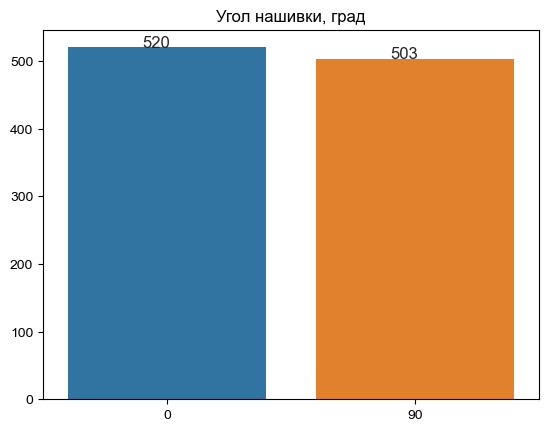

In [8]:
bar_polt('Угол нашивки, град')

In [9]:
numeric = data.select_dtypes([float]).columns
categorical = data.select_dtypes(['category']).columns

------------------------------------
 Описание: 


count    1023.000000
mean        6.899222
std         2.563467
min         0.000000
25%         5.080033
50%         6.916144
75%         8.586293
max        14.440522
Name: Шаг нашивки, dtype: float64

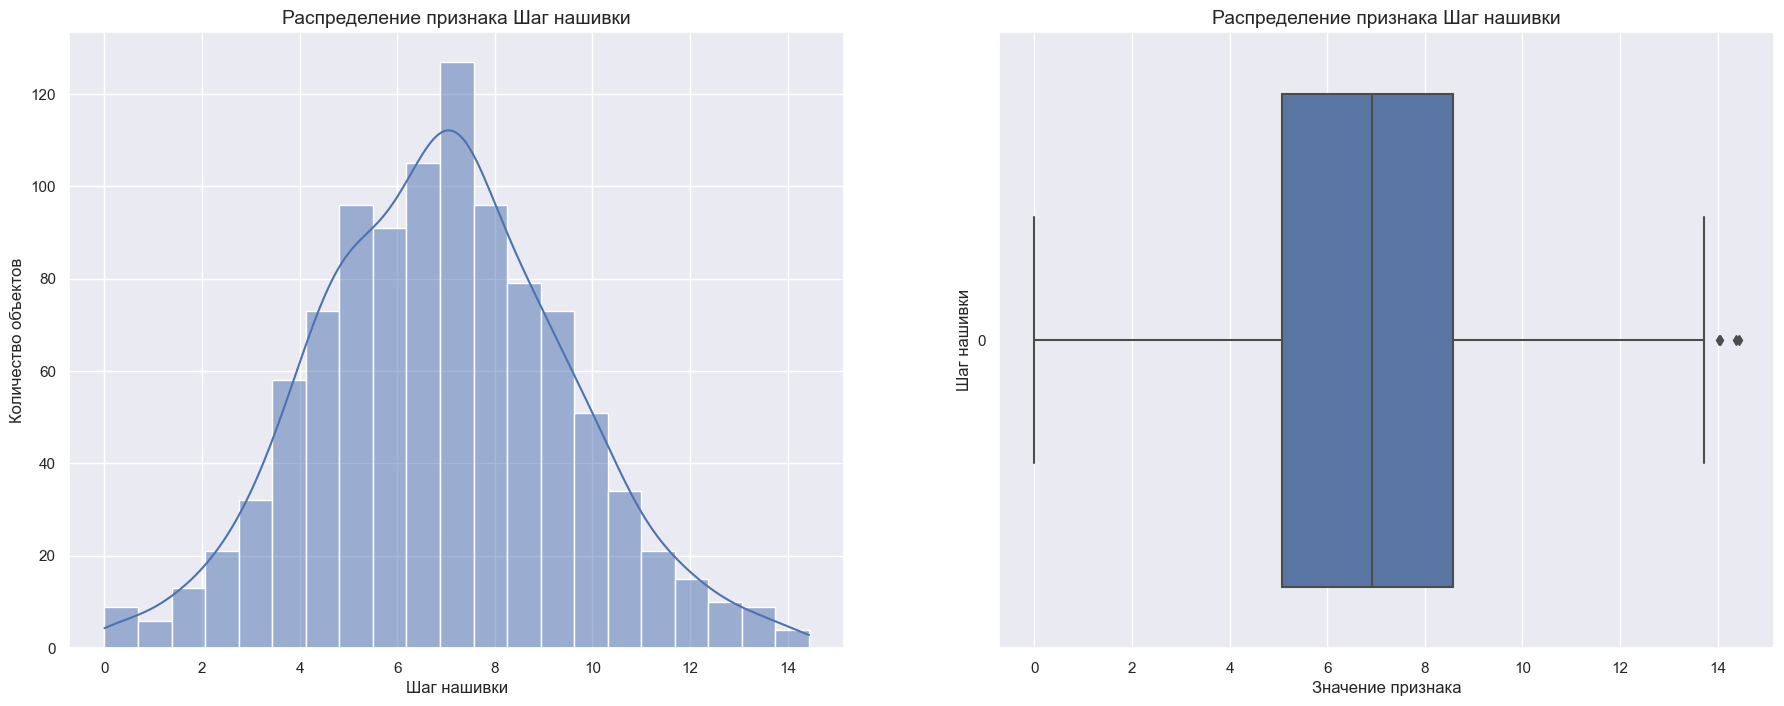

------------------------------------
 Описание: 


count    1023.000000
mean       57.153929
std        12.350969
min         0.000000
25%        49.799212
50%        57.341920
75%        64.944961
max       103.988901
Name: Плотность нашивки, dtype: float64

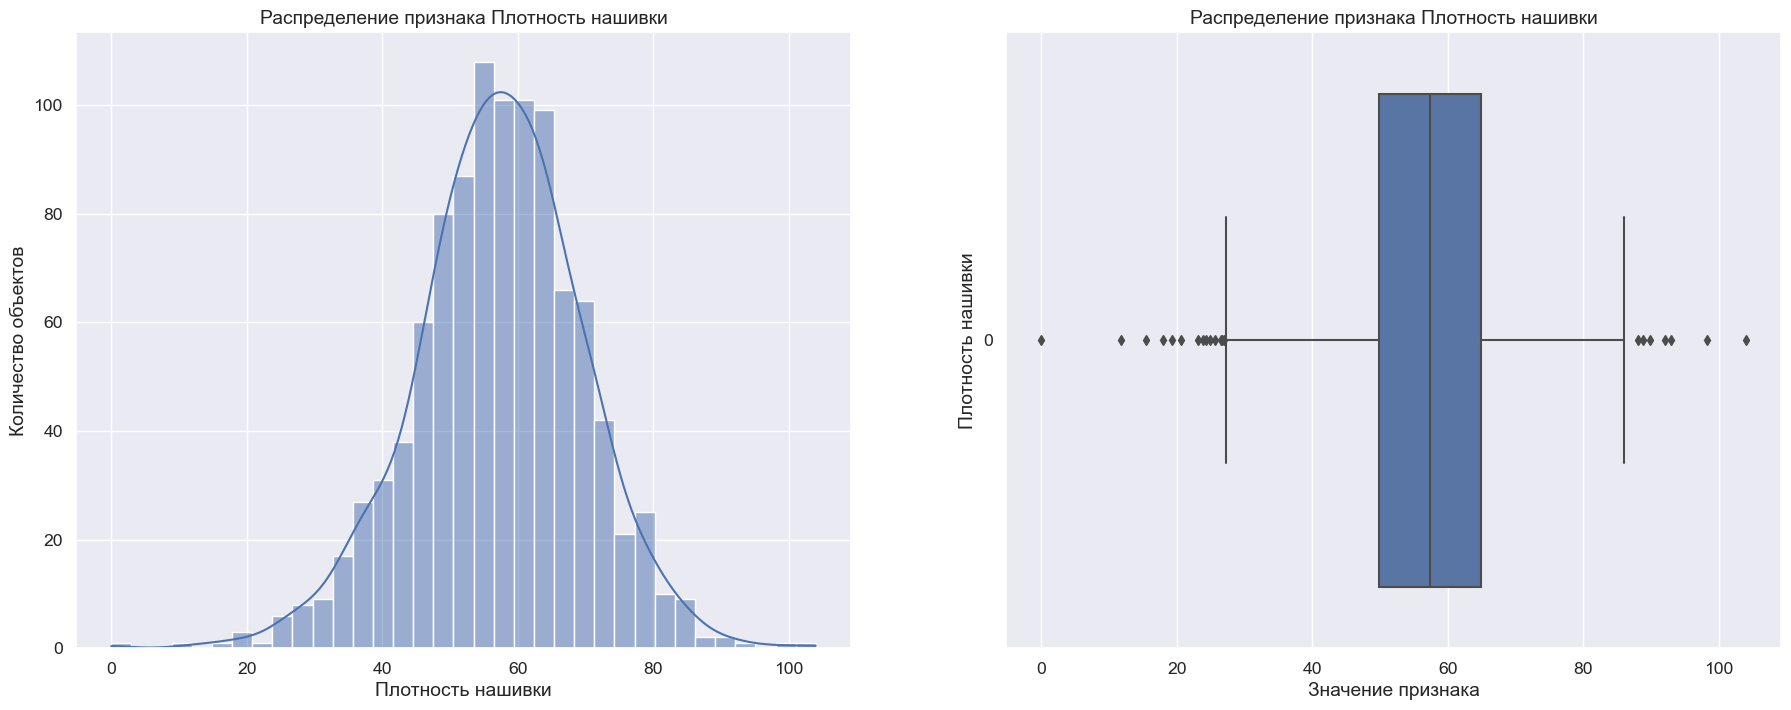

------------------------------------
 Описание: 


count    1023.000000
mean        2.930366
std         0.913222
min         0.389403
25%         2.317887
50%         2.906878
75%         3.552660
max         5.591742
Name: Соотношение матрица-наполнитель, dtype: float64

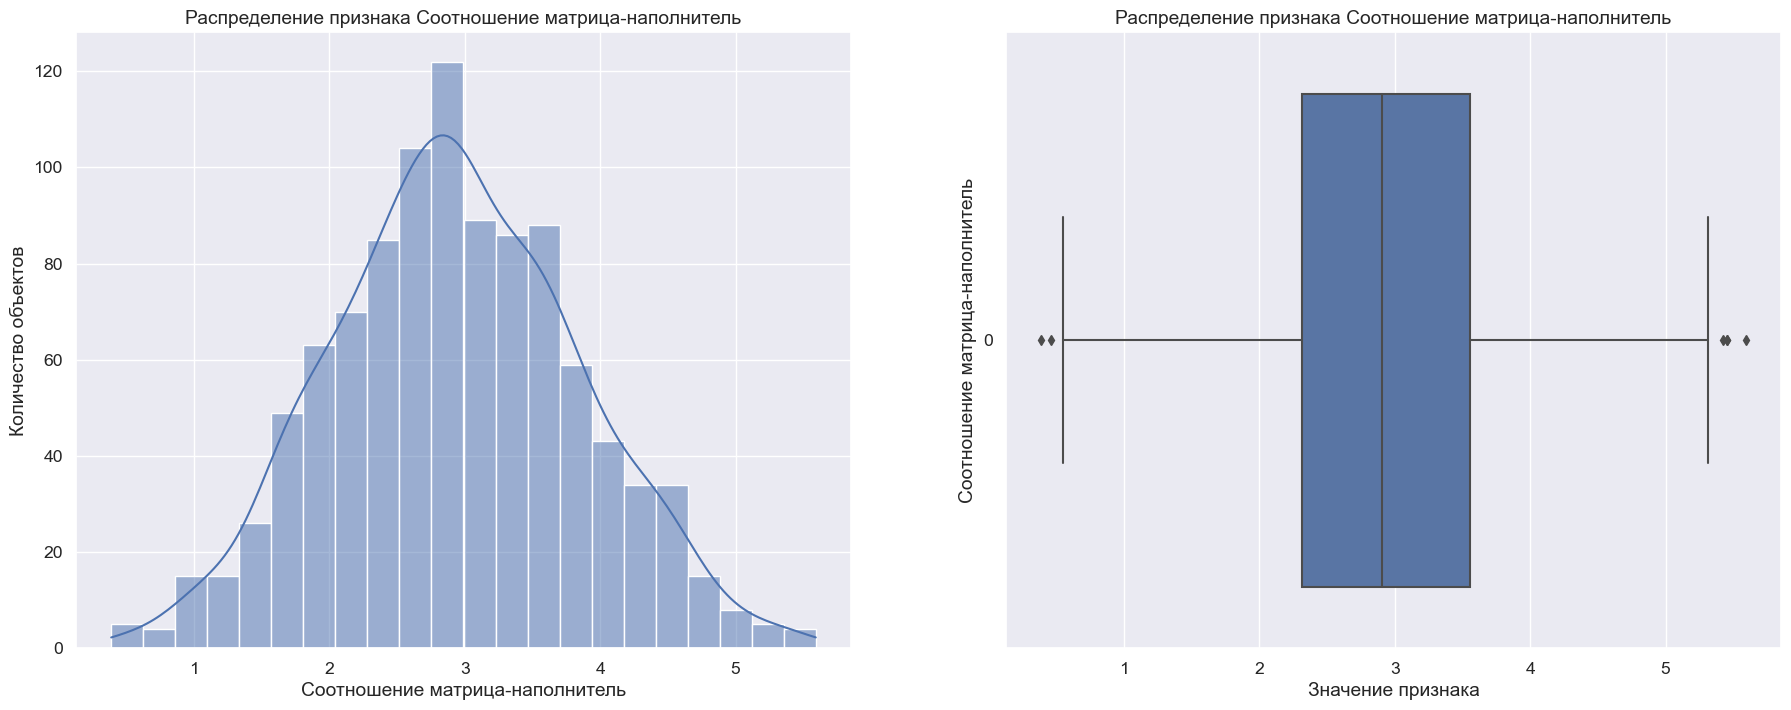

------------------------------------
 Описание: 


count    1023.000000
mean     1975.734888
std        73.729231
min      1731.764635
25%      1924.155467
50%      1977.621657
75%      2021.374375
max      2207.773481
Name: Плотность, кг/м3, dtype: float64

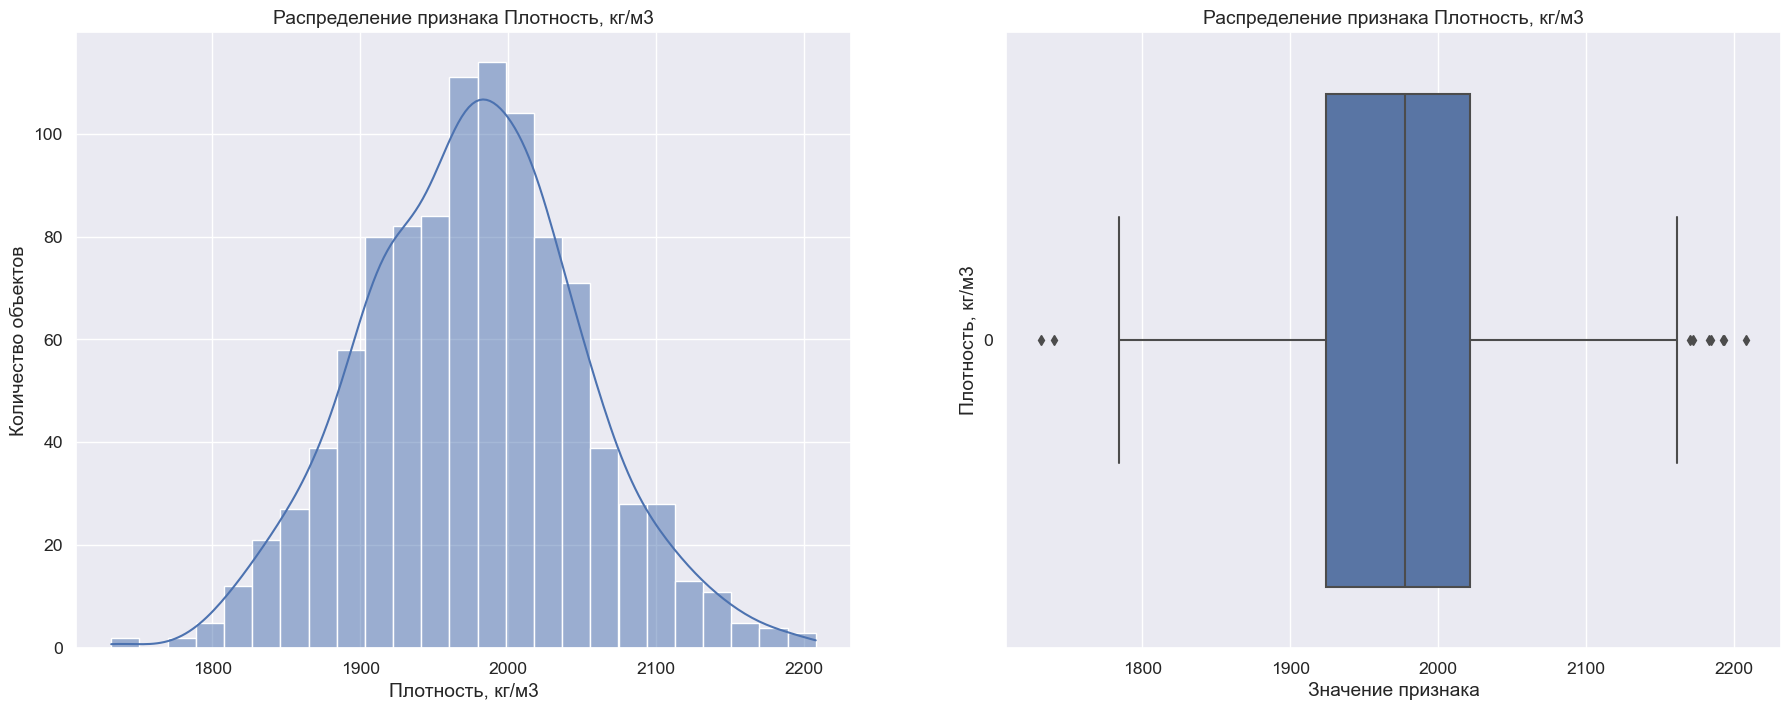

------------------------------------
 Описание: 


count    1023.000000
mean      739.923233
std       330.231581
min         2.436909
25%       500.047452
50%       739.664328
75%       961.812526
max      1911.536477
Name: модуль упругости, ГПа, dtype: float64

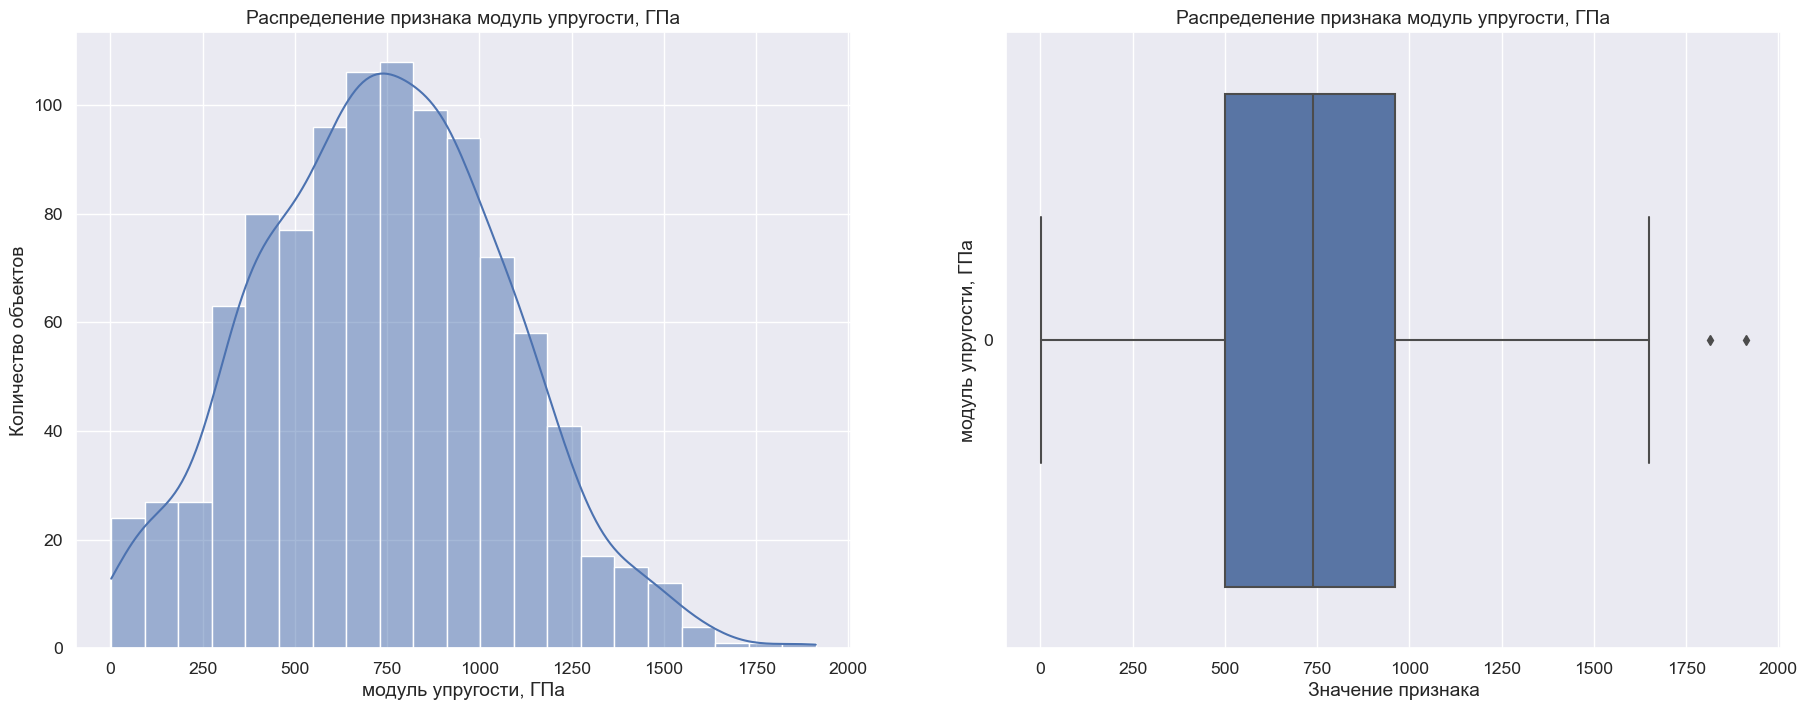

------------------------------------
 Описание: 


count    1023.000000
mean      110.570769
std        28.295911
min        17.740275
25%        92.443497
50%       110.564840
75%       129.730366
max       198.953207
Name: Количество отвердителя, м.%, dtype: float64

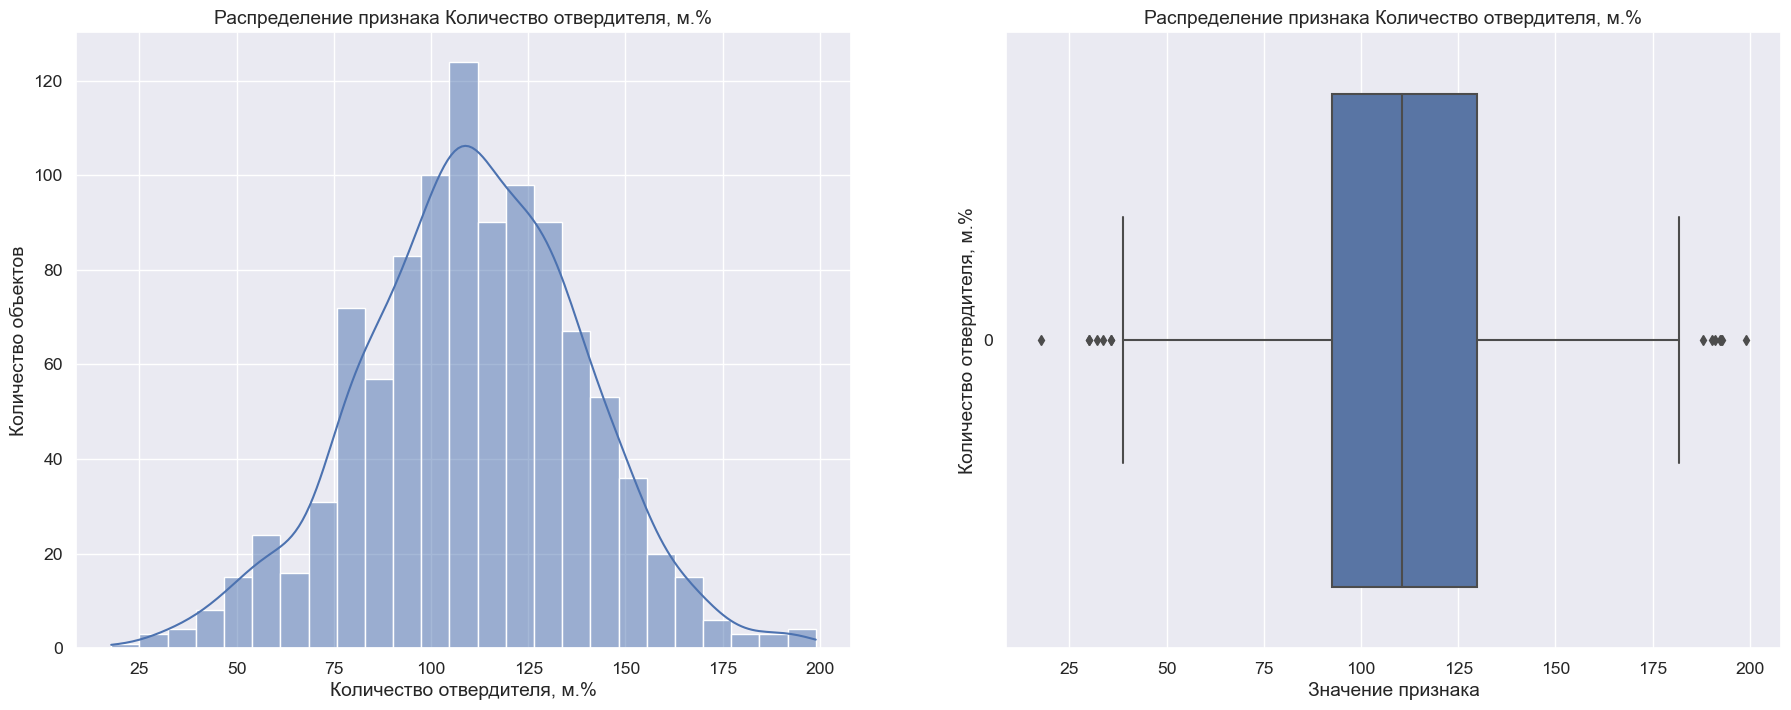

------------------------------------
 Описание: 


count    1023.000000
mean       22.244390
std         2.406301
min        14.254985
25%        20.608034
50%        22.230744
75%        23.961934
max        33.000000
Name: Содержание эпоксидных групп,%_2, dtype: float64

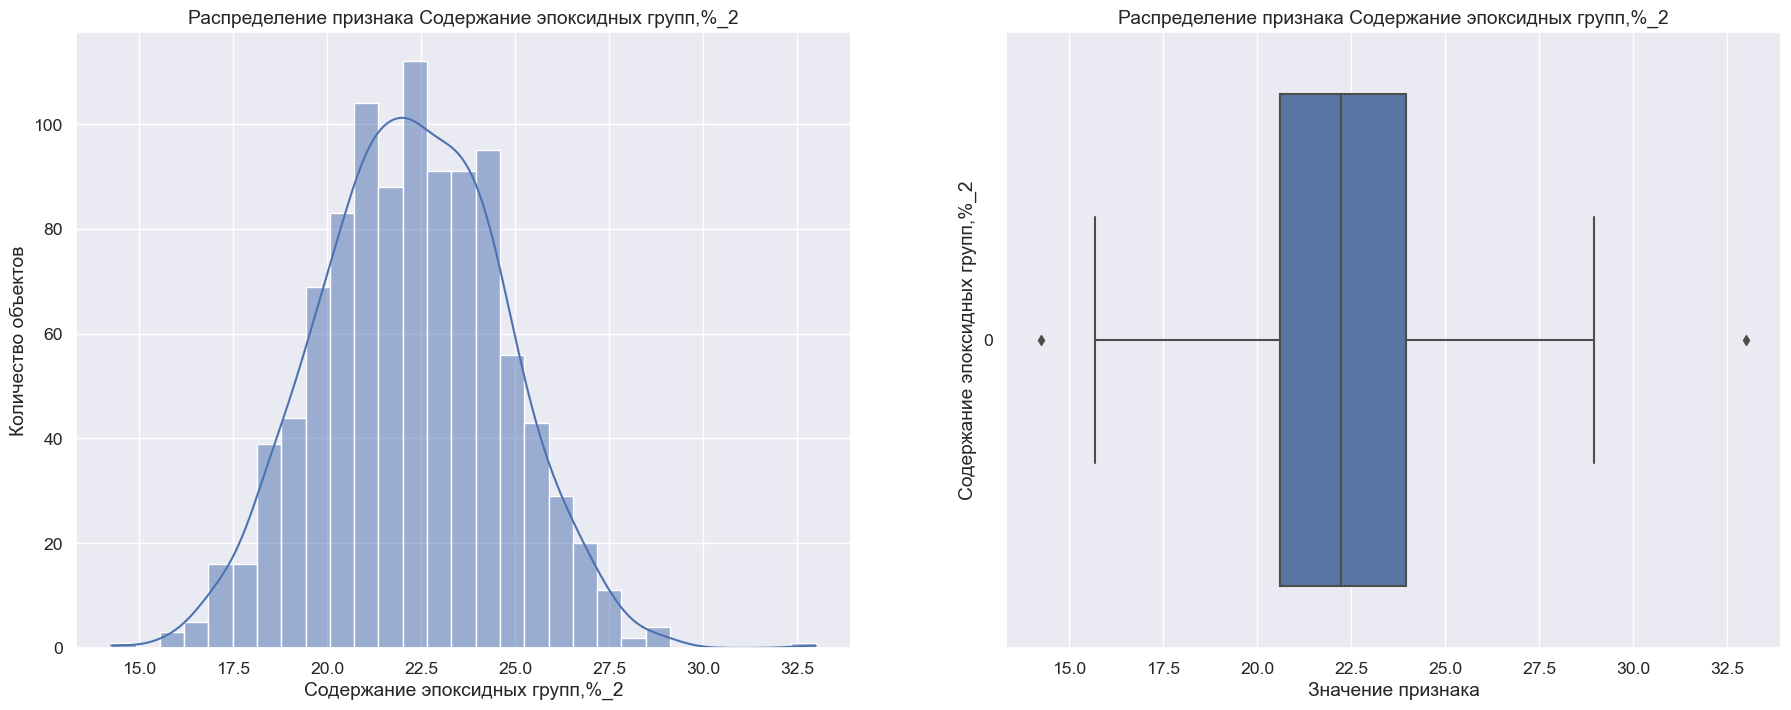

------------------------------------
 Описание: 


count    1023.000000
mean      285.882151
std        40.943260
min       100.000000
25%       259.066528
50%       285.896812
75%       313.002106
max       413.273418
Name: Температура вспышки, С_2, dtype: float64

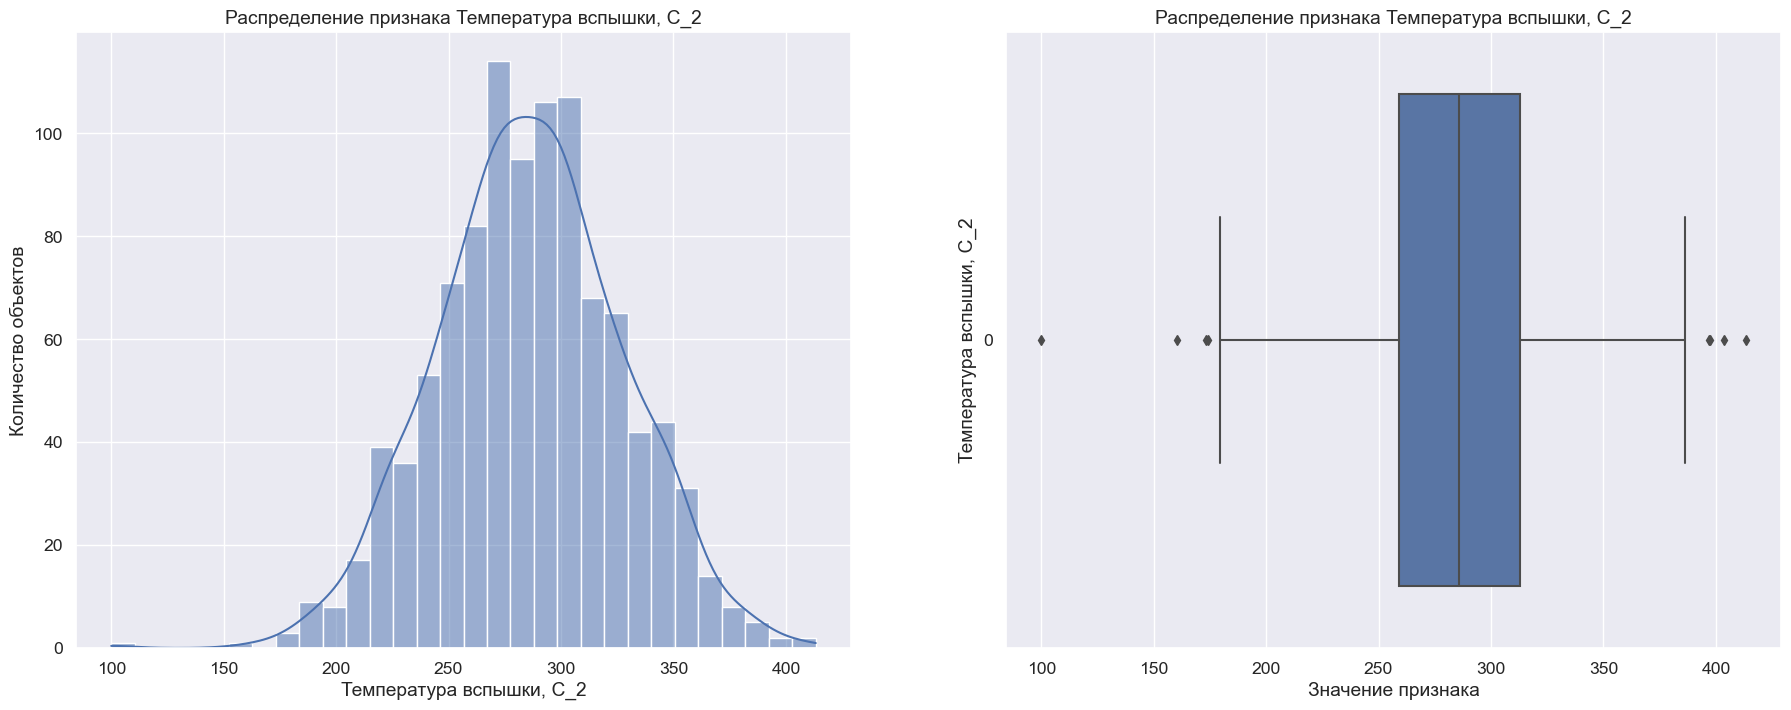

------------------------------------
 Описание: 


count    1023.000000
mean      482.731833
std       281.314690
min         0.603740
25%       266.816645
50%       451.864365
75%       693.225017
max      1399.542362
Name: Поверхностная плотность, г/м2, dtype: float64

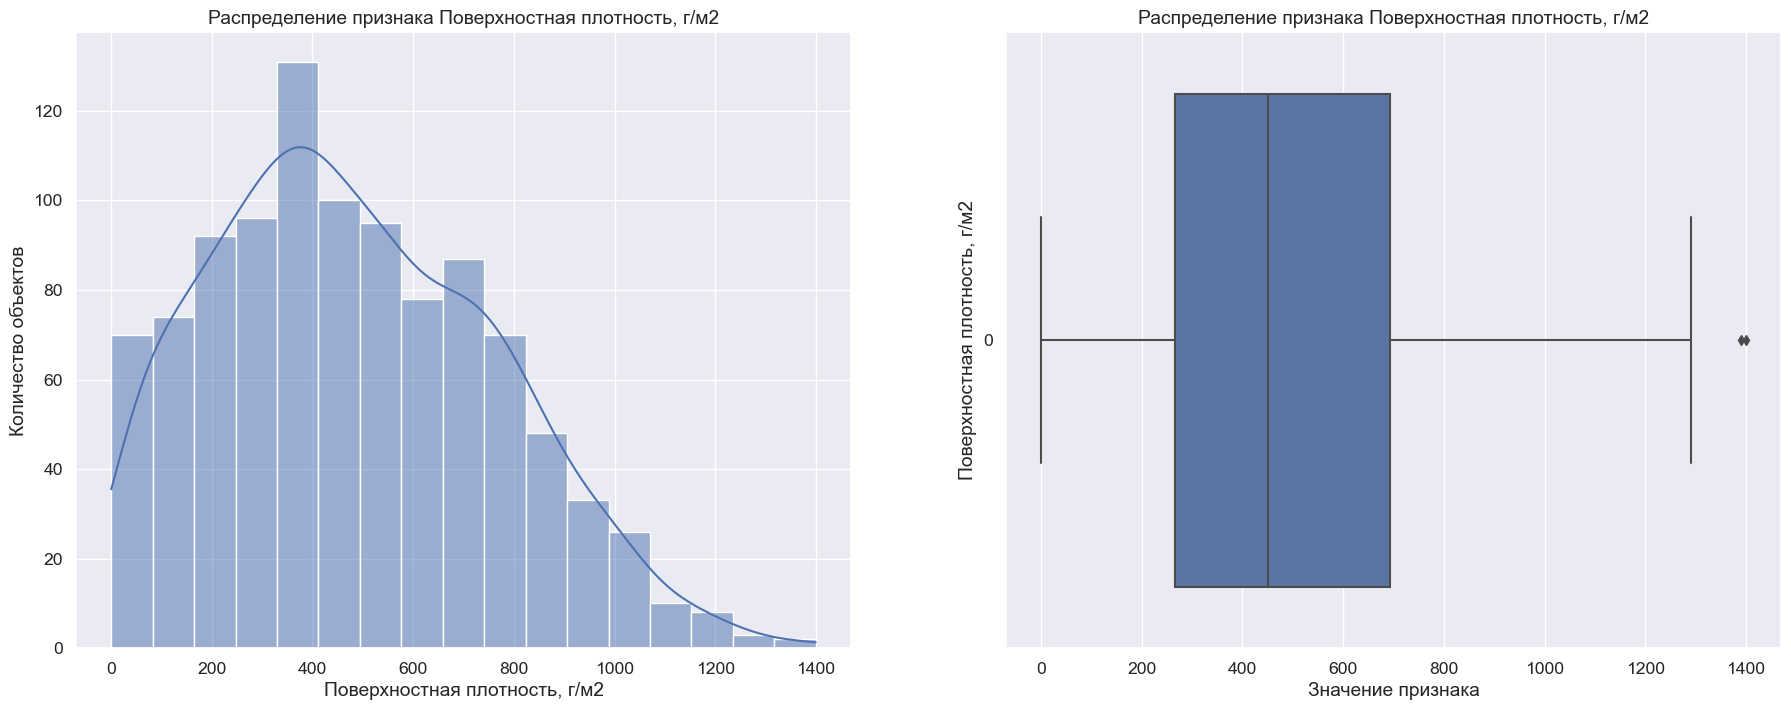

------------------------------------
 Описание: 


count    1023.000000
mean       73.328571
std         3.118983
min        64.054061
25%        71.245018
50%        73.268805
75%        75.356612
max        82.682051
Name: Модуль упругости при растяжении, ГПа, dtype: float64

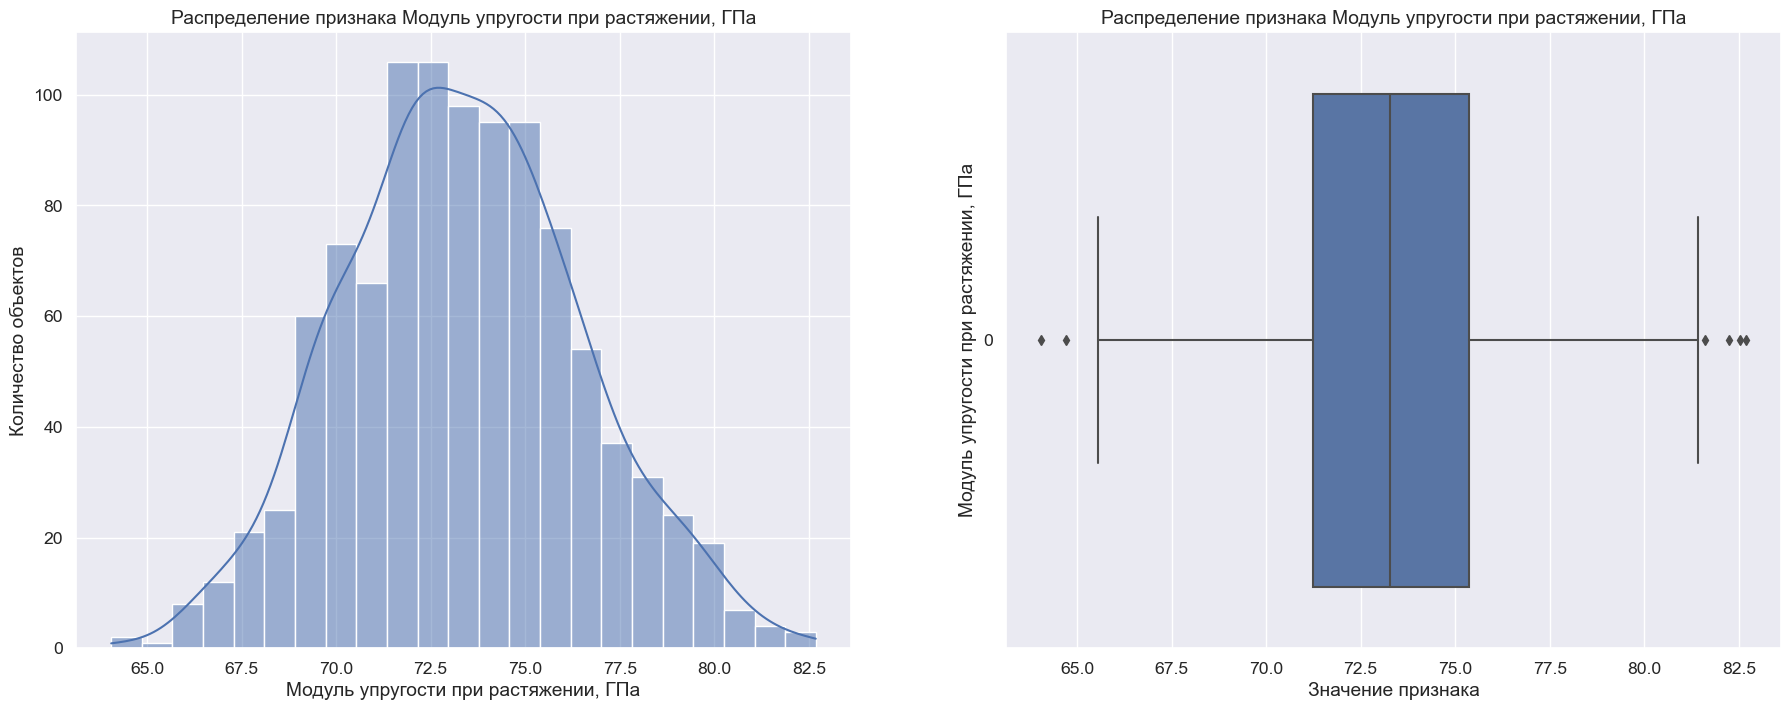

------------------------------------
 Описание: 


count    1023.000000
mean     2466.922843
std       485.628006
min      1036.856605
25%      2135.850448
50%      2459.524526
75%      2767.193119
max      3848.436732
Name: Прочность при растяжении, МПа, dtype: float64

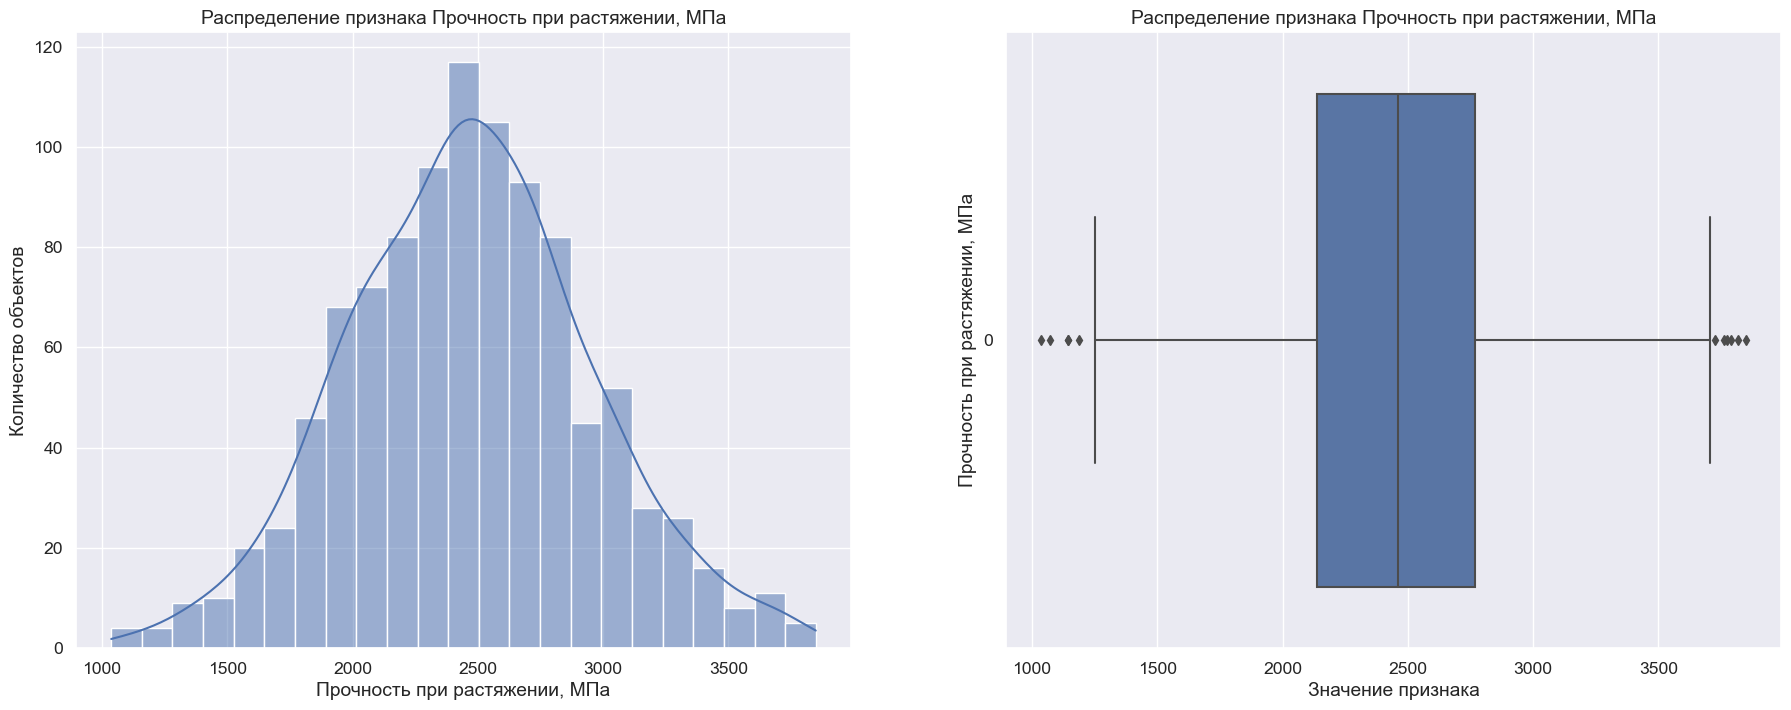

------------------------------------
 Описание: 


count    1023.000000
mean      218.423144
std        59.735931
min        33.803026
25%       179.627520
50%       219.198882
75%       257.481724
max       414.590628
Name: Потребление смолы, г/м2, dtype: float64

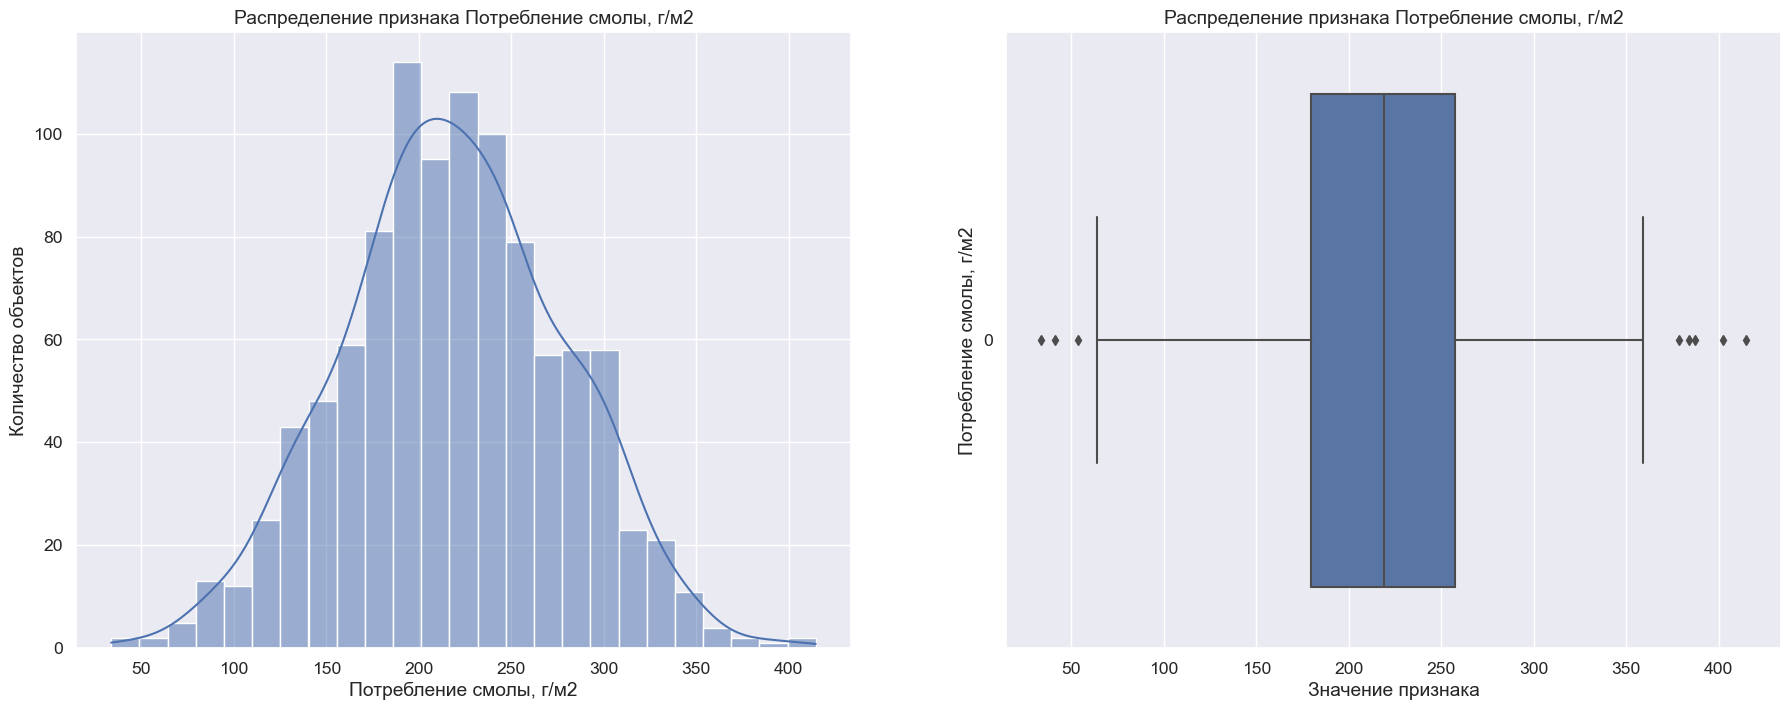

In [10]:
def describe_plot(column):

    print("-"*36)
    print(f"{Style.BRIGHT}{Fore.BLUE} Описание: {Style.RESET_ALL}")
    display(data[column].describe())

    fig, axs = plt.subplots(ncols=2,figsize=(22, 8))
    sns.set(font_scale=1.15)

    gr1 = sns.histplot(data[i], kde=True, ax=axs[0])
    gr2 = sns.boxplot(data[i], orient='h', ax=axs[1])

    gr1.set(title=f'Распределение признака {column}', xlabel=f'{column}', ylabel='Количество объектов')
    gr2.set(title=f'Распределение признака {column}', xlabel='Значение признака', ylabel=f'{column}')
    plt.show()
    
for i in numeric:
    describe_plot(i)

Удалим аномалии 

In [11]:
def find_anomalies(data):
    anomalies_idx = []
    
    random_data_std = np.std(data)
    random_data_mean = np.mean(data)
    anomaly_cut_off = random_data_std * 3
    
    lower_limit  = random_data_mean - anomaly_cut_off 
    upper_limit = random_data_mean + anomaly_cut_off

    
    for outlier_idx in range(len(data)):
        if data[outlier_idx] > upper_limit or data[outlier_idx] < lower_limit:
            anomalies_idx.append(outlier_idx)
    return anomalies_idx


for num in numeric:
    anomalies_idx = find_anomalies(data[num])
    data = data.drop(anomalies_idx, axis=0).reset_index(drop=True)

------------------------------------
 Описание: 


count    999.000000
mean       6.910734
std        2.559025
min        0.037639
25%        5.098161
50%        6.928247
75%        8.591215
max       14.440522
Name: Шаг нашивки, dtype: float64

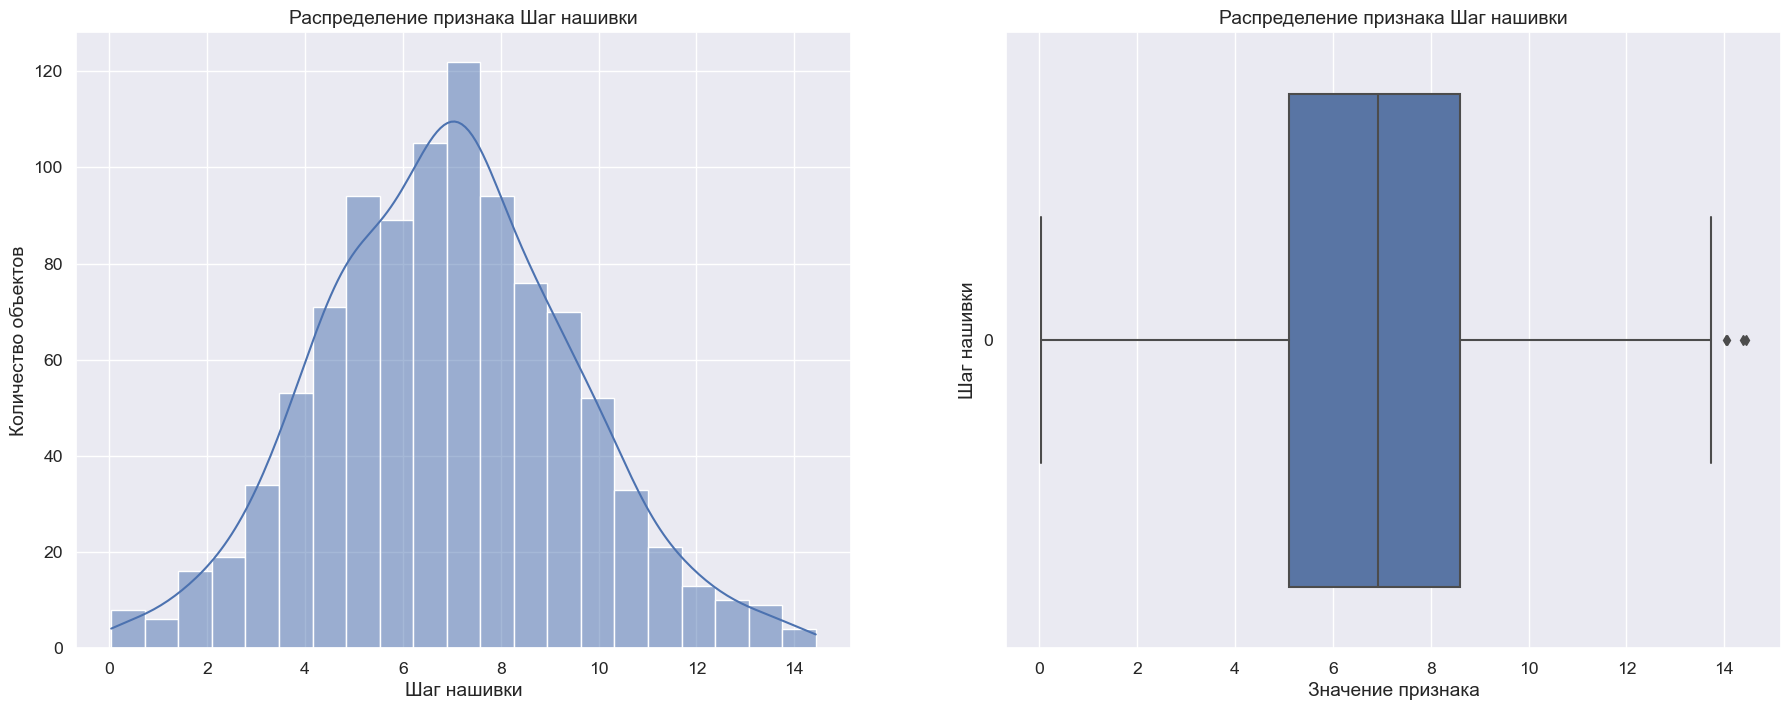

------------------------------------
 Описание: 


count    999.000000
mean      57.283879
std       11.849293
min       20.571633
25%       49.946682
50%       57.499988
75%       64.944961
max       92.963492
Name: Плотность нашивки, dtype: float64

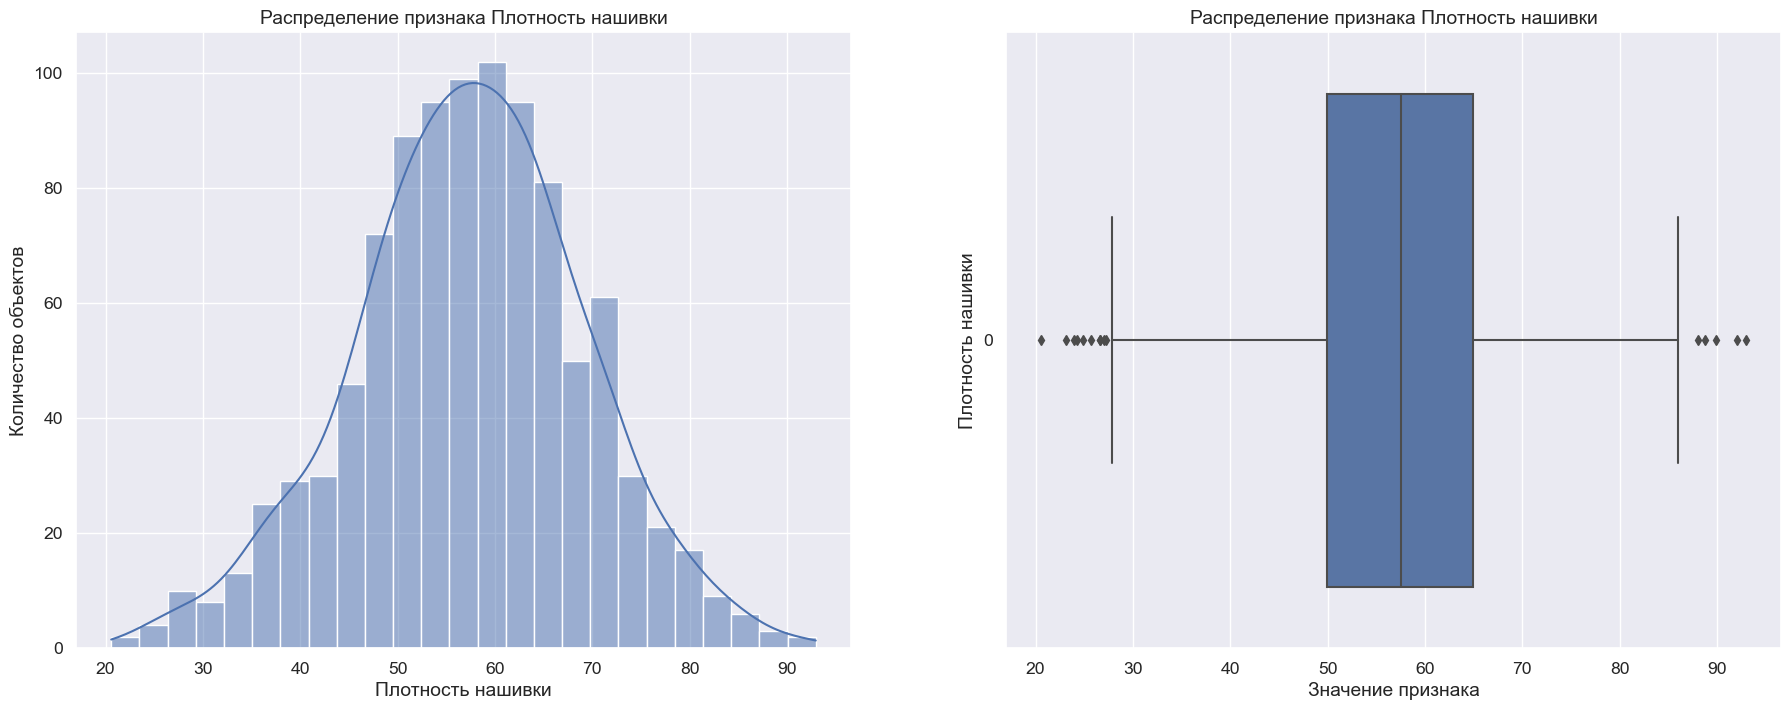

------------------------------------
 Описание: 


count    999.000000
mean       2.937129
std        0.908854
min        0.389403
25%        2.321061
50%        2.908835
75%        3.554960
max        5.591742
Name: Соотношение матрица-наполнитель, dtype: float64

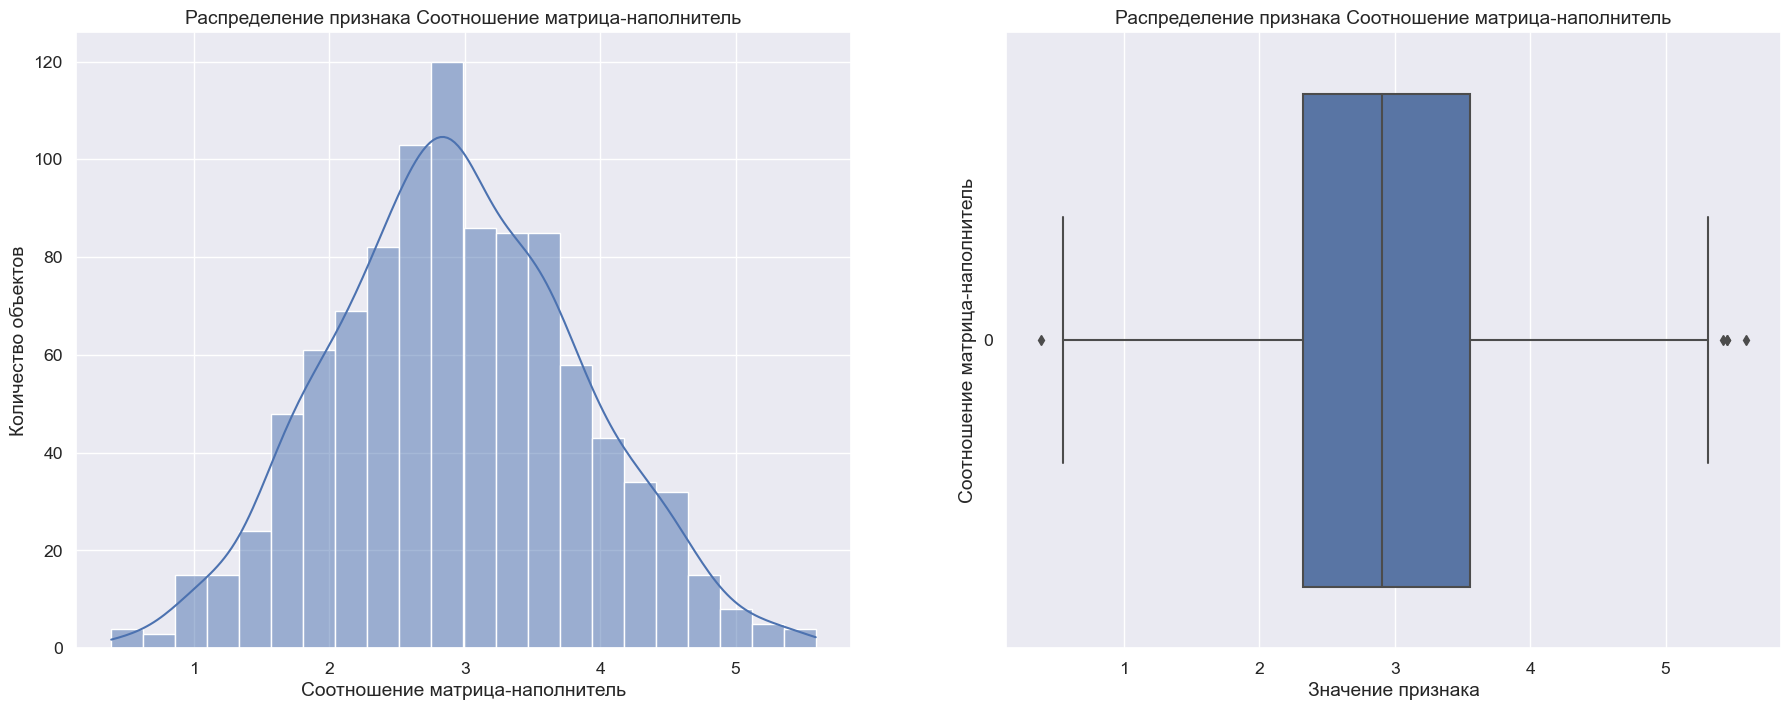

------------------------------------
 Описание: 


count     999.000000
mean     1975.463852
std        72.964410
min      1784.482245
25%      1923.706033
50%      1977.339047
75%      2021.173086
max      2192.738783
Name: Плотность, кг/м3, dtype: float64

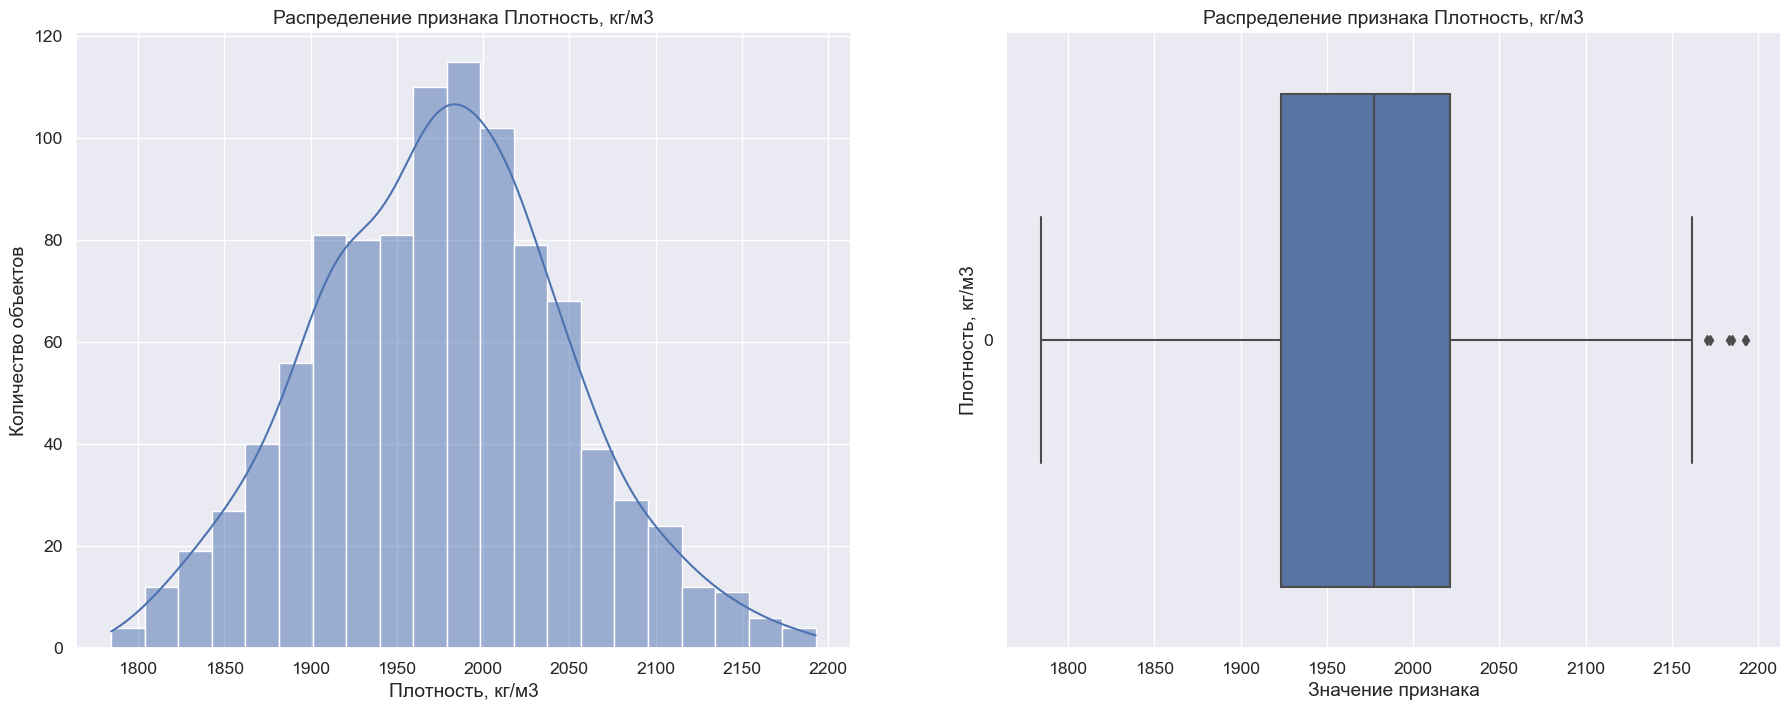

------------------------------------
 Описание: 


count     999.000000
mean      738.450188
std       327.631773
min         2.436909
25%       500.047452
50%       741.037038
75%       959.442359
max      1649.415706
Name: модуль упругости, ГПа, dtype: float64

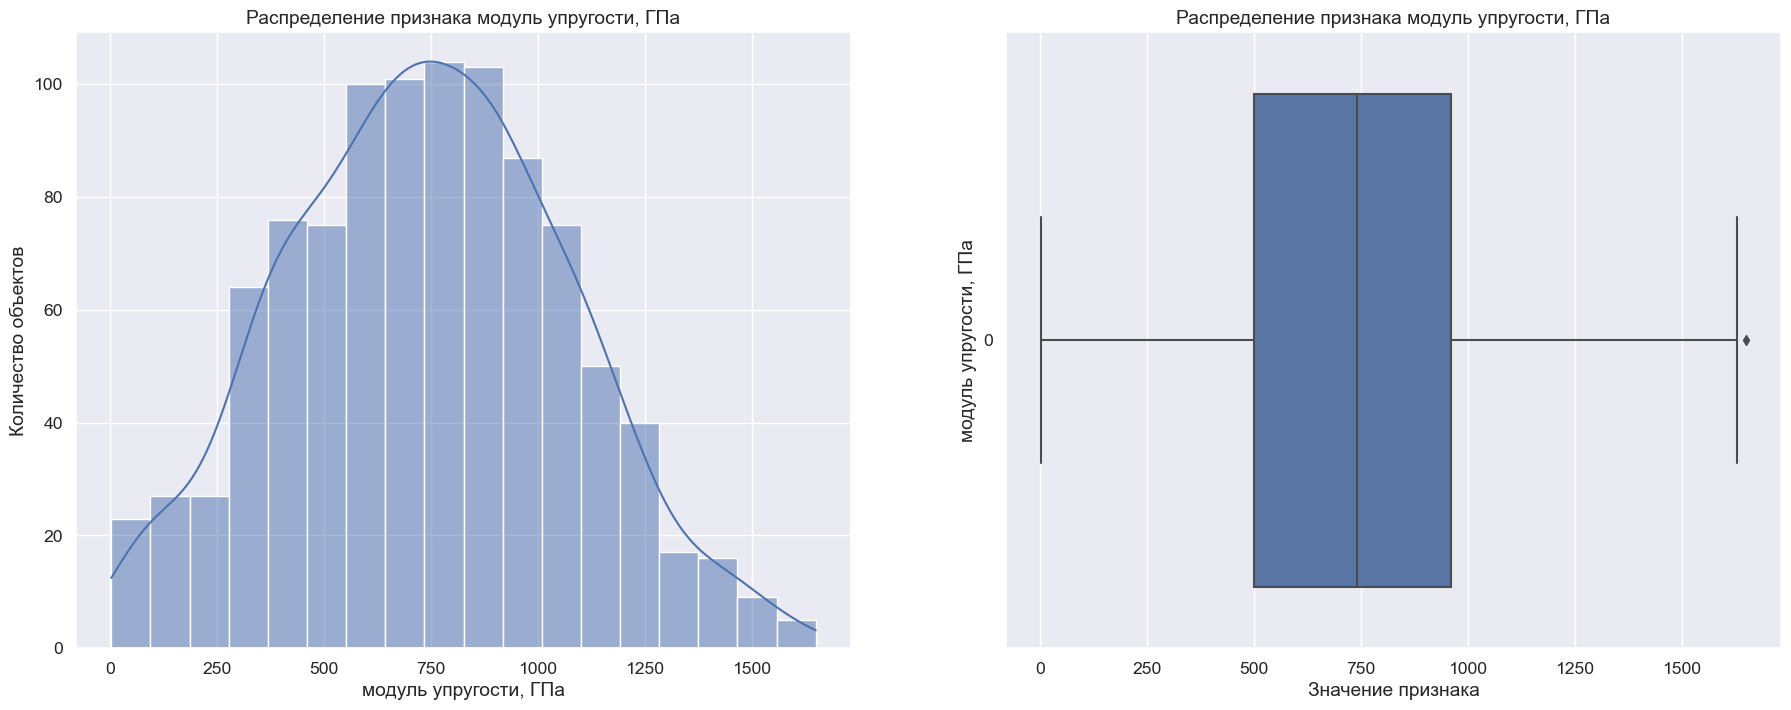

------------------------------------
 Описание: 


count    999.000000
mean     110.874067
std       27.834697
min       29.956150
25%       92.577613
50%      110.689775
75%      129.884490
max      192.851702
Name: Количество отвердителя, м.%, dtype: float64

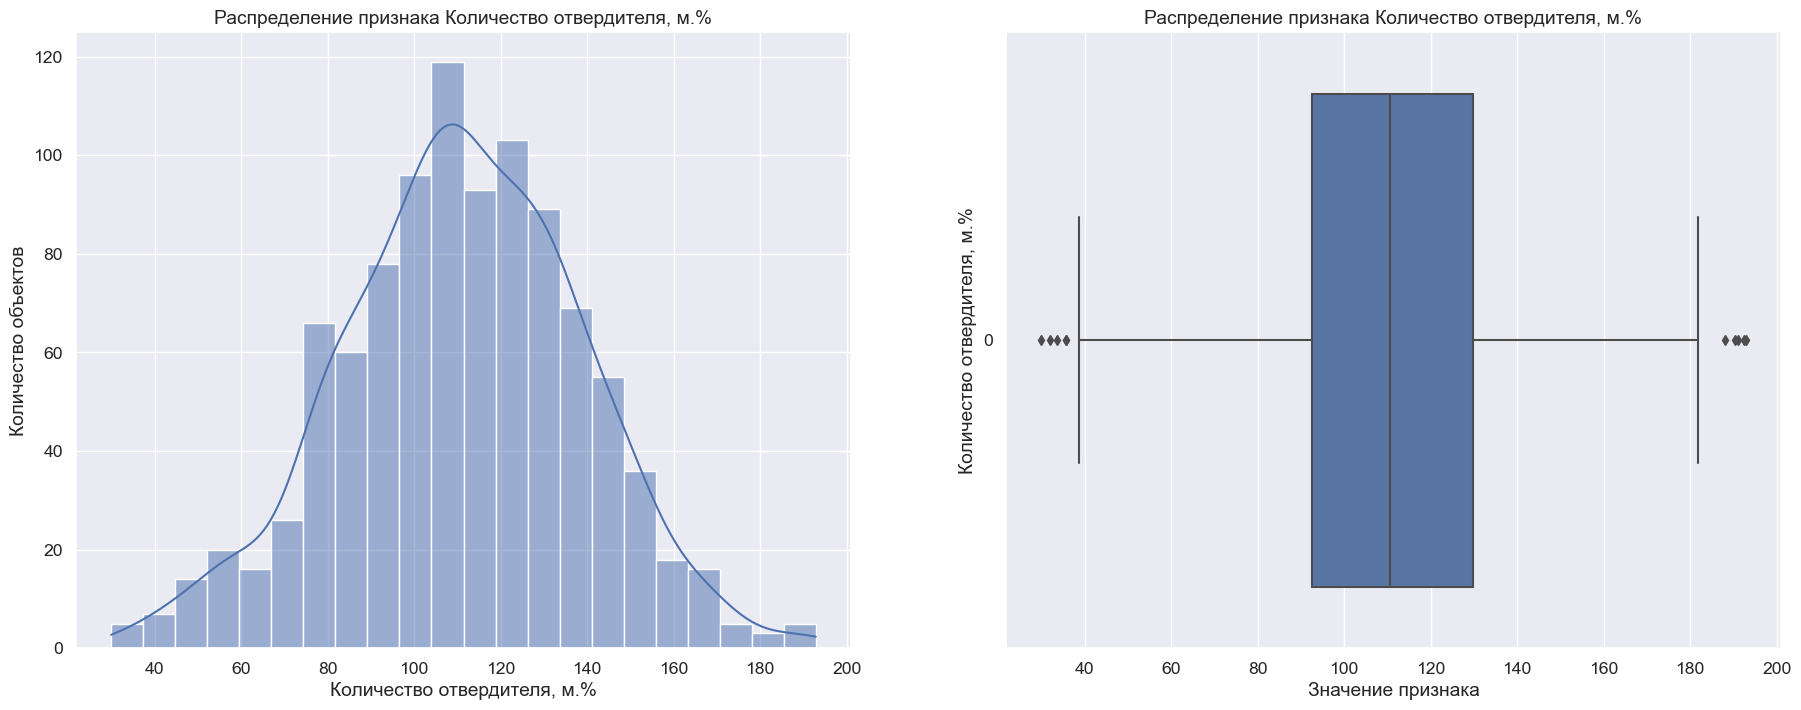

------------------------------------
 Описание: 


count    999.000000
mean      22.233969
std        2.384916
min       15.695894
25%       20.583073
50%       22.220097
75%       23.976789
max       28.955094
Name: Содержание эпоксидных групп,%_2, dtype: float64

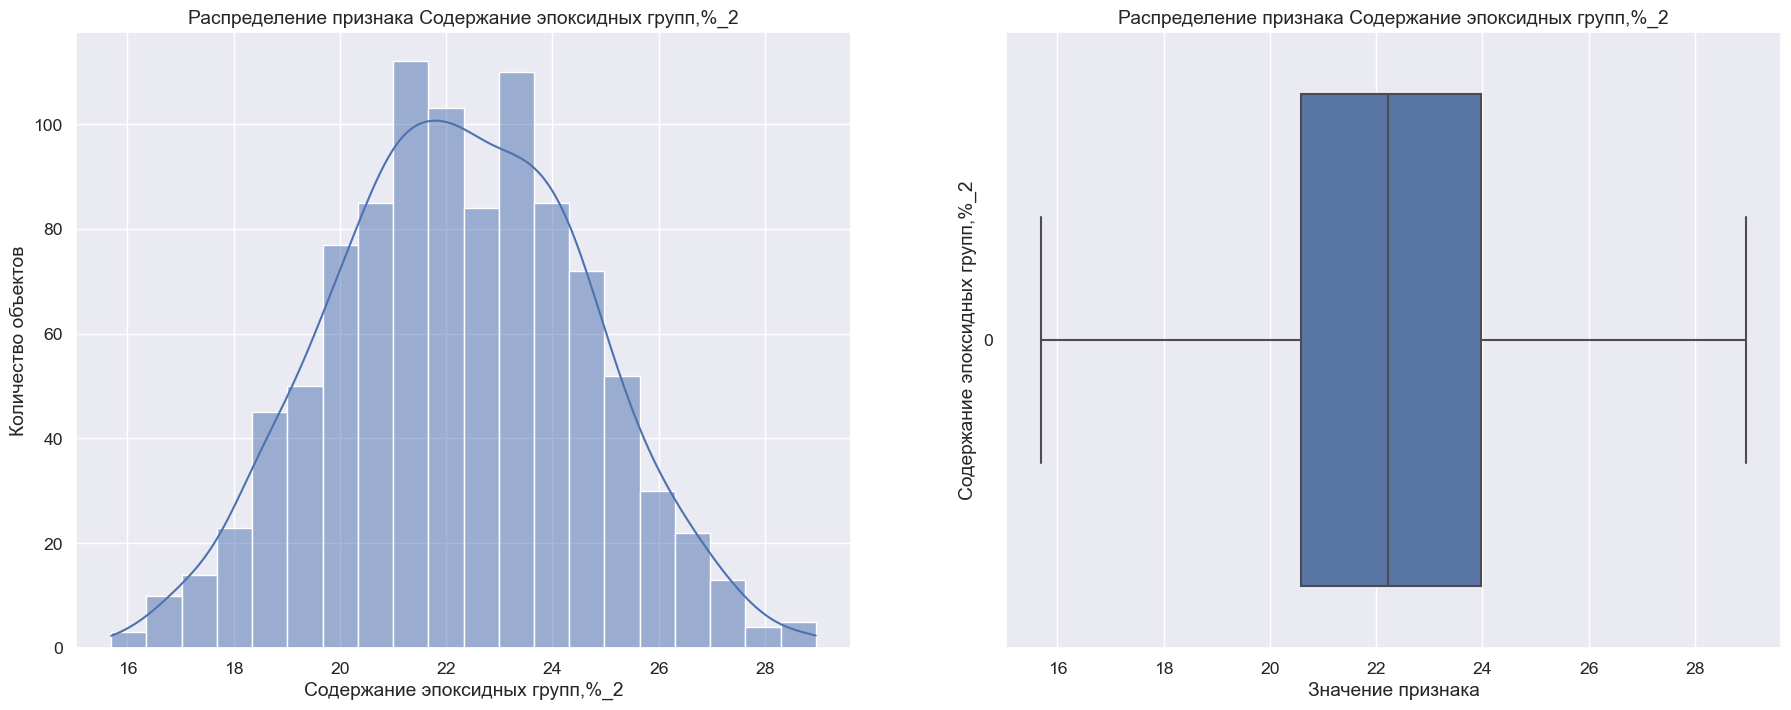

------------------------------------
 Описание: 


count    999.000000
mean     285.964652
std       40.250987
min      173.484920
25%      259.066528
50%      285.896812
75%      313.034785
max      403.652861
Name: Температура вспышки, С_2, dtype: float64

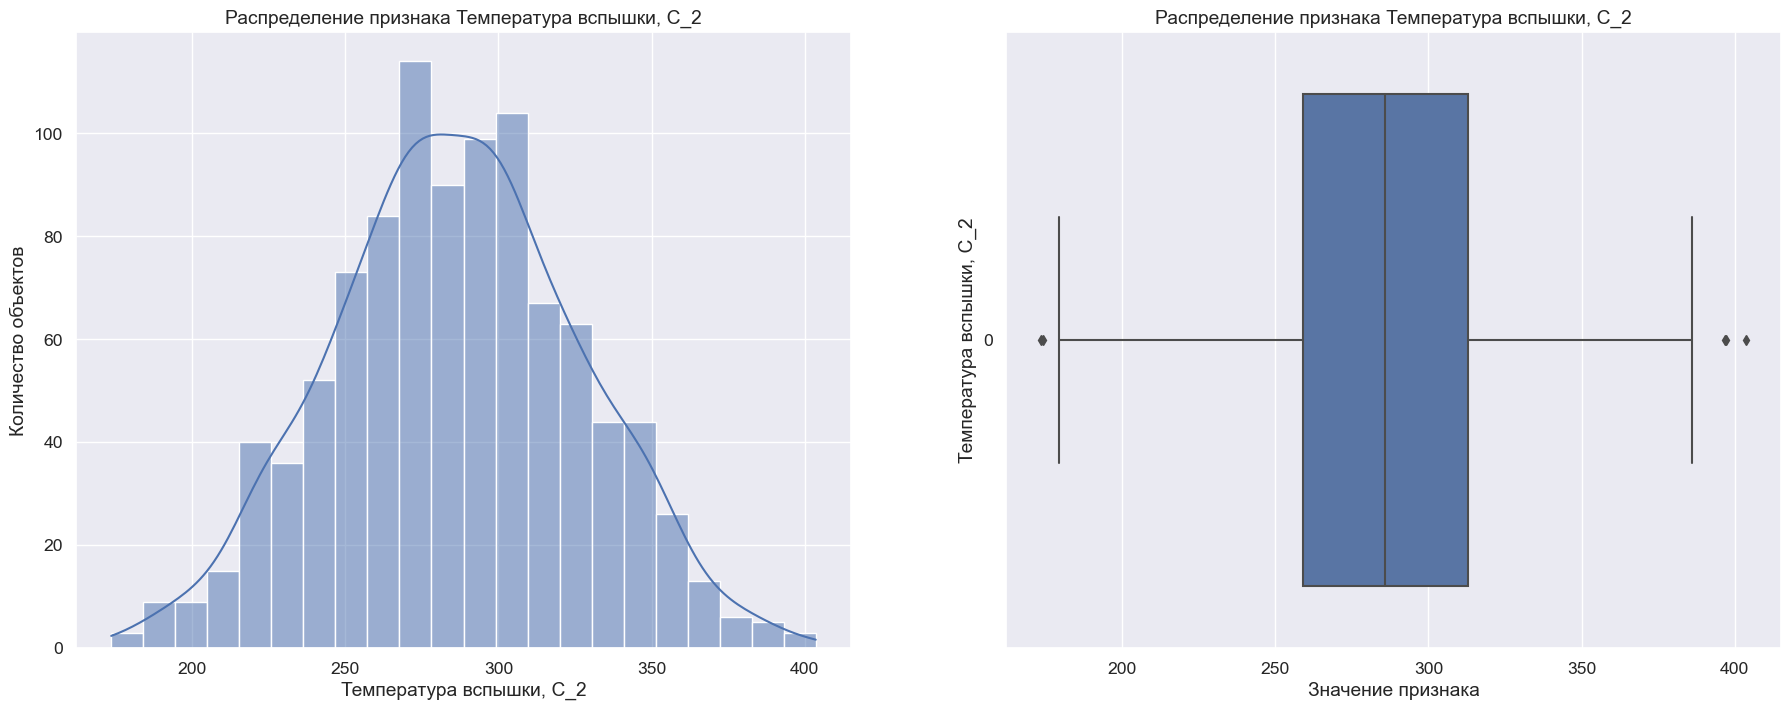

------------------------------------
 Описание: 


count     999.000000
mean      479.541965
std       277.670164
min         0.603740
25%       266.816645
50%       450.429300
75%       690.822854
max      1291.340115
Name: Поверхностная плотность, г/м2, dtype: float64

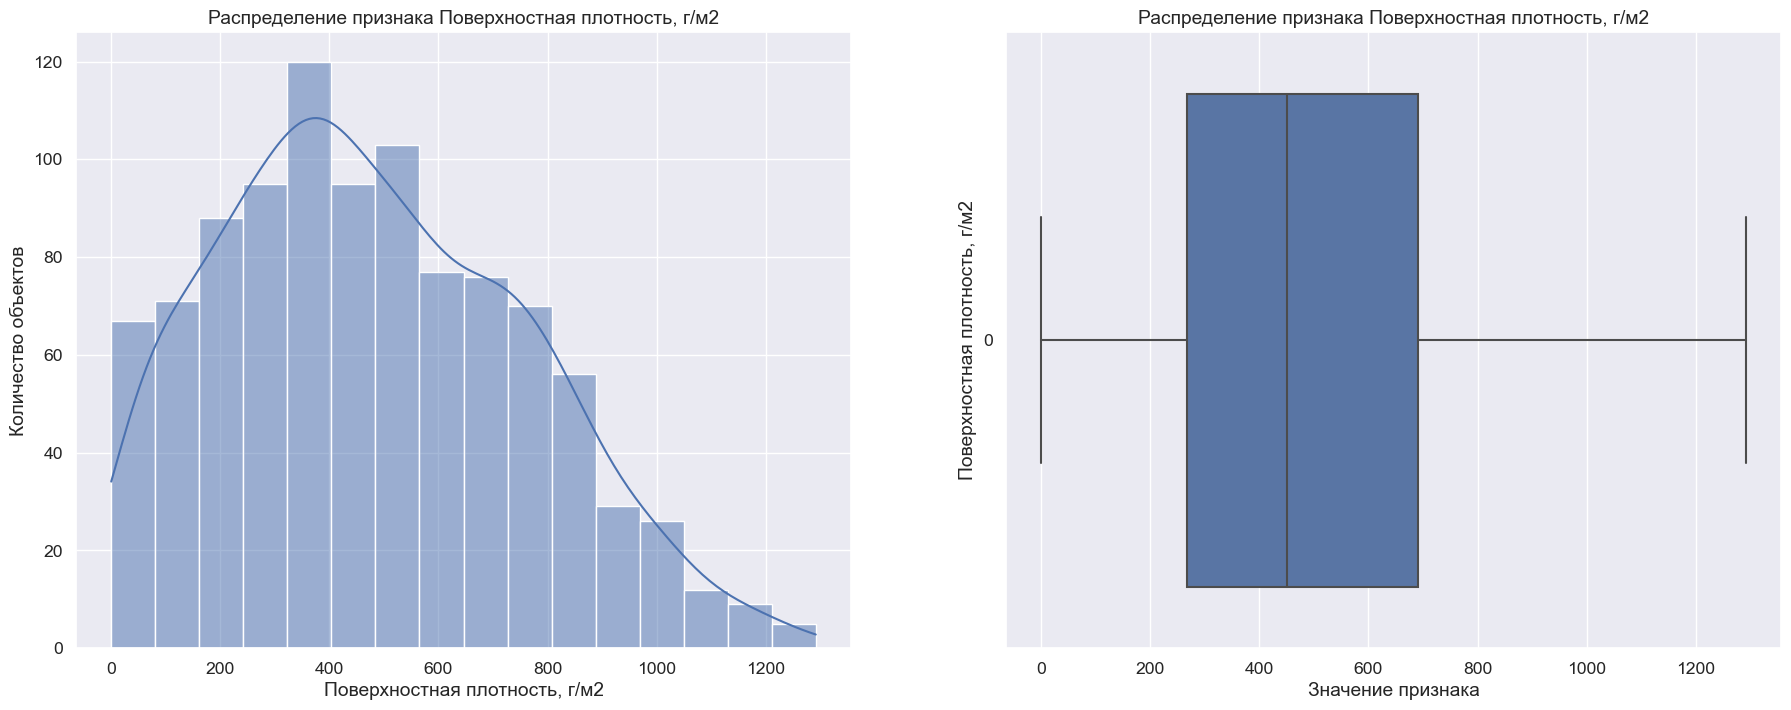

------------------------------------
 Описание: 


count    999.000000
mean      73.308804
std        3.101230
min       64.054061
25%       71.245018
50%       73.219286
75%       75.322176
max       82.525773
Name: Модуль упругости при растяжении, ГПа, dtype: float64

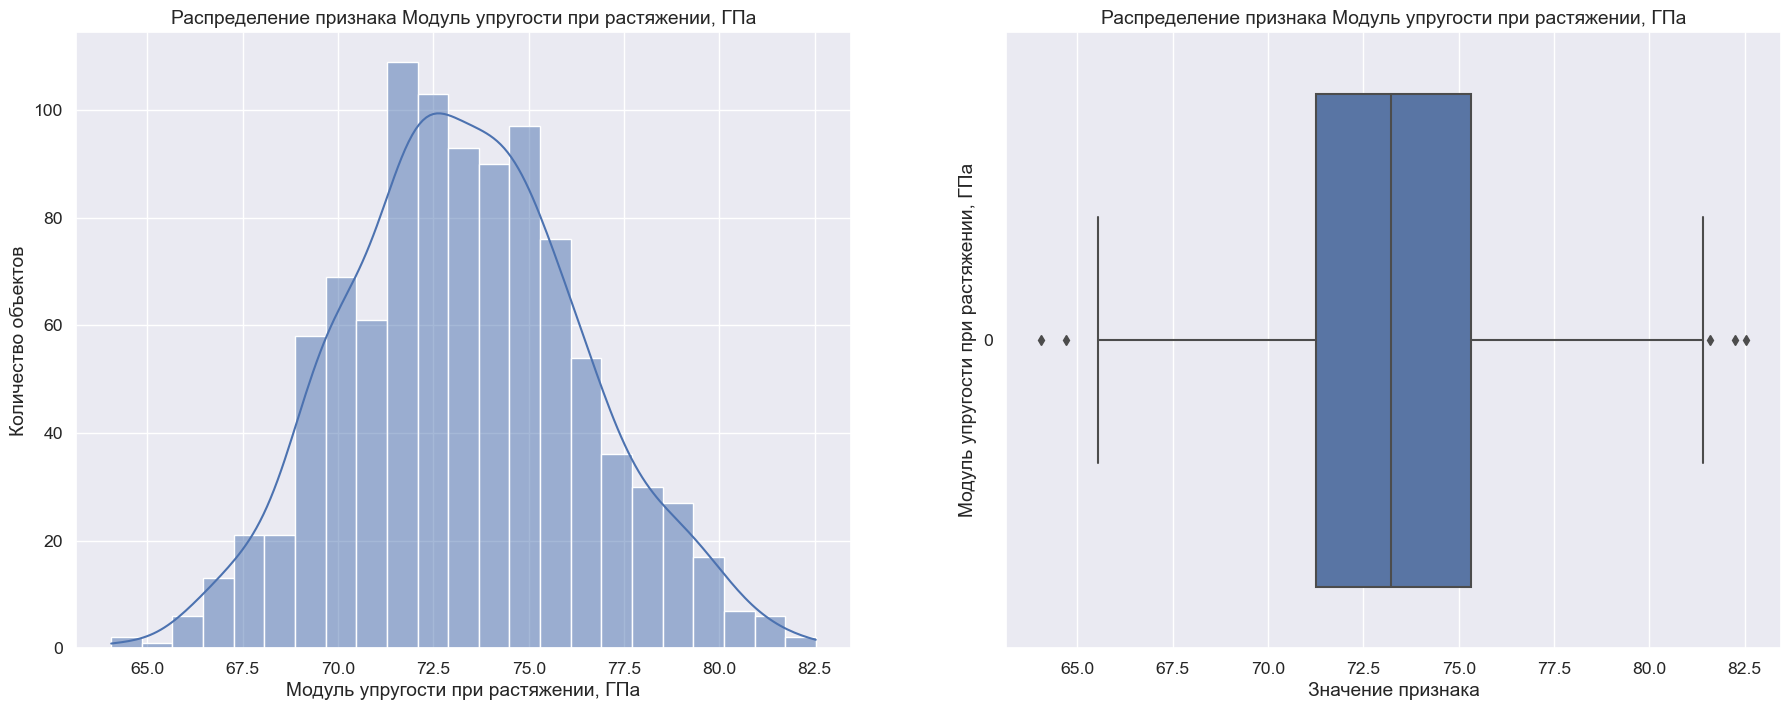

------------------------------------
 Описание: 


count     999.000000
mean     2465.907130
std       484.135114
min      1036.856605
25%      2135.292972
50%      2456.395009
75%      2760.573255
max      3848.436732
Name: Прочность при растяжении, МПа, dtype: float64

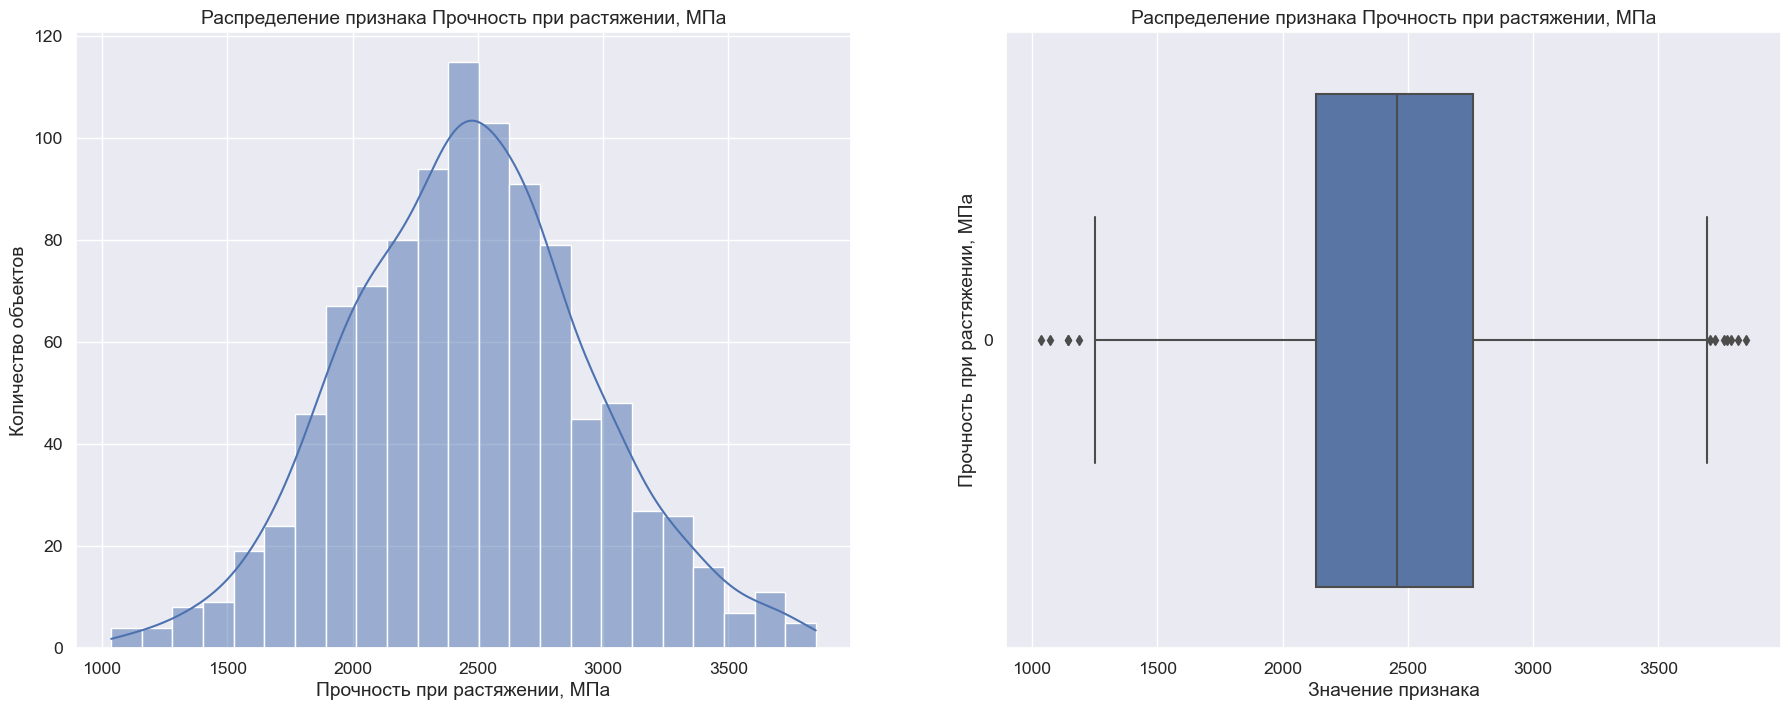

------------------------------------
 Описание: 


count    999.000000
mean     218.188960
std       58.938558
min       41.048278
25%      179.766002
50%      218.448971
75%      257.330831
max      386.903431
Name: Потребление смолы, г/м2, dtype: float64

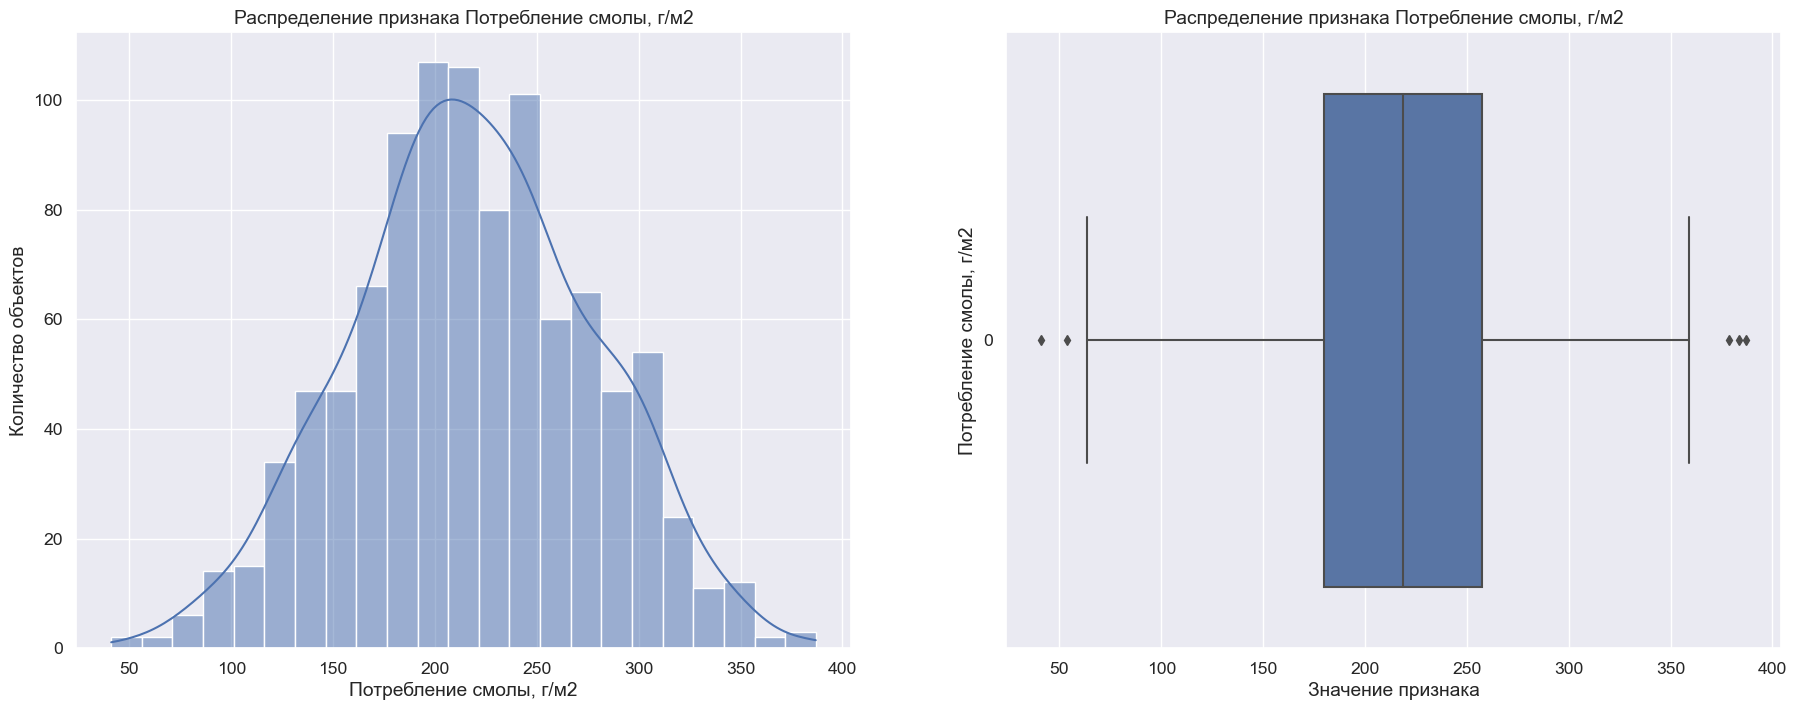

In [12]:
for i in numeric:
    describe_plot(i)

In [13]:
feature = data.drop(columns=['Модуль упругости при растяжении, ГПа', 'Прочность при растяжении, МПа'], axis=1)
target = data[['Модуль упругости при растяжении, ГПа', 'Прочность при растяжении, МПа']]

X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.3, random_state=RANDOM_STATE)

### LGBMRegressor

In [14]:
numeric = X_train.select_dtypes([float]).columns

col_transformer = ColumnTransformer(
                        transformers=[
                            ('scaler', StandardScaler(), numeric),
                            ('ohe', OneHotEncoder(sparse=False, drop='first'), categorical)],
                                remainder="passthrough"
                                  )

In [15]:
pipeline_light = Pipeline(steps=[
                            ('transformer', col_transformer),
                            ('light', MultiOutputRegressor(LGBMRegressor(random_state=RANDOM_STATE)))
                          ])

parameters = {
    'light__estimator__n_estimators': range(1, 50),
    'light__estimator__max_depth': range(1, 10),
    'light__estimator__learning_rate': [0.1, 0.5, 0.05, 0.025, 0.0005, 0.04]
}

grid_search_light = GridSearchCV(pipeline_light, parameters, cv=10, n_jobs=-1, scoring='neg_root_mean_squared_error', verbose=1)
grid_search_light.fit(X_train, y_train)

print(f"Best score: {abs(grid_search_light.best_score_):.3f}, Best params: {grid_search_light.best_params_}")

Fitting 10 folds for each of 2646 candidates, totalling 26460 fits
Best score: 243.389, Best params: {'light__estimator__learning_rate': 0.5, 'light__estimator__max_depth': 1, 'light__estimator__n_estimators': 15}


### DecisionTreeRegressor

In [16]:
pipeline_tree = Pipeline(steps=[
                            ('transformer', col_transformer),
                            ('tree',  DecisionTreeRegressor(random_state=RANDOM_STATE))
                          ])

parameters = {
    'tree__min_samples_split': range(2, 10),
    'tree__min_samples_leaf': range(1, 10),
    'tree__max_depth': range(1, 10)
}



grid_search_tree = GridSearchCV(pipeline_tree, parameters, cv=10, n_jobs=-1, 
                                       scoring='neg_root_mean_squared_error', verbose=3)
grid_search_tree.fit(X_train, y_train);

print(f"Best score: {abs(grid_search_tree.best_score_):.3f}, Best params: {grid_search_tree.best_params_}")

Fitting 10 folds for each of 648 candidates, totalling 6480 fits
Best score: 248.053, Best params: {'tree__max_depth': 1, 'tree__min_samples_leaf': 7, 'tree__min_samples_split': 2}


### SGDRegressor

In [17]:
pipeline_sgd = Pipeline(steps=[
                            ('transformer', col_transformer),
                            ('sgd',  MultiOutputRegressor(SGDRegressor(random_state=RANDOM_STATE)))
                          ])

parameters = {
    'sgd__estimator__loss': ['squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'sgd__estimator__penalty': ['l2', 'l1', 'elasticnet', None],
    'sgd__estimator__max_iter': range(50, 100, 10),
}



grid_search_sgd = GridSearchCV(pipeline_sgd, parameters, cv=10, n_jobs=-1, 
                                       scoring='neg_root_mean_squared_error', verbose=3)
grid_search_sgd.fit(X_train, y_train);

print(f"Best score: {abs(grid_search_sgd.best_score_):.3f}, Best params: {grid_search_sgd.best_params_}")

Fitting 10 folds for each of 80 candidates, totalling 800 fits
Best score: 247.137, Best params: {'sgd__estimator__loss': 'squared_error', 'sgd__estimator__max_iter': 50, 'sgd__estimator__penalty': 'l2'}


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


### Тестирование

In [18]:
rmse_test = mean_squared_error(grid_search_light.predict(X_test), y_test, squared=False)
print(f"RMSE on test: {rmse_test:.3f}")

RMSE on test: 242.111
